### Introduction 
<br/>

Part II: Machine Learning

### Import Libraries

In [1]:
import os, sys, time, gc, warnings, re 
import datetime as dt

import itertools as it
import operator as op

import numpy as np
import scipy.stats as stats
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

sys.path.append(os.environ["PY_UTILITIES_LIBRARY"]) # PY_UTILITIES_LIBRARY points to our custom library

%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -iv -d -t -v -w -m

json      2.0.9
pandas    0.24.2
re        2.2.1
matplotlib3.0.3
scipy     1.2.1
seaborn   0.9.0
numpy     1.16.2
2019-05-21 04:05:03 

CPython 3.6.8
IPython 7.5.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
watermark 1.8.0


### Configure Notebook

In [3]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('io.hdf.default_format','fixed') # store binary data in HDF5 'table' format or 'fixed' format
sns.set(context='paper', style="darkgrid", rc={'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor':'white'}, 
        font_scale=1.3)
HTML("<style>table {font-size:14px} </style>")

def printmd(string, color=None):
    """colors in hex"""
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [4]:
%reload_ext autoreload
%autoreload 2

rs_seed = np.random.RandomState(seed=43)

### Define Notebook Parameters

In [5]:
# see papermill package
train_file = "./CAX_MortgageModeling_Train.csv"
test_file = "./CAX_MortgageModeling_Test.csv"

submission_fields = ["Unique_ID", "Result_Predicted"]
target = "RESULT"
object_id = "Unique_ID"

In [6]:
# imports
from functools import partial

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold, ShuffleSplit, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

from ml_toolbelt.mlutils.train_lgbm import LGBMCVClassifier
from ml_toolbelt.mlutils.train_catboost import CatCVClassifier
from ml_toolbelt.mlutils.metrics import logit
from ml_toolbelt.utils.stat_utils import describe_categorical, describe_numeric

from catboost.utils import eval_metric, select_threshold
import lightgbm as lgbm

warnings.filterwarnings("ignore")

### Data

In [7]:
train_df = pd.read_csv(train_file)
print(train_df.shape)
test_df = pd.read_csv(test_file)
print(test_df.shape)

print(train_df.info())
test_df.drop(["RESULT"], axis=1, inplace=True)
print("\n",test_df.shape)

train_df.head()

(45642, 22)
(15214, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 22 columns):
Unique_ID            45642 non-null object
MORTGAGE NUMBER      45642 non-null int64
PROPERTY VALUE       45642 non-null int64
MORTGAGE PAYMENT     45642 non-null int64
GDS                  45642 non-null float64
LTV                  45642 non-null float64
TDS                  45642 non-null float64
AMORTIZATION         45642 non-null int64
MORTGAGE AMOUNT      45642 non-null float64
RATE                 45642 non-null float64
MORTGAGE PURPOSE     45642 non-null object
PAYMENT FREQUENCY    45642 non-null object
PROPERTY TYPE        45642 non-null object
TERM                 45642 non-null int64
FSA                  45642 non-null object
AGE RANGE            45642 non-null object
GENDER               45642 non-null object
INCOME               45642 non-null int64
INCOME TYPE          45642 non-null int64
NAICS CODE           45642 non-null object
CREDIT SC

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.980,65.000,71.630,360,1040000.000,4.000,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,FUNDED
1,CAX_Train_2,2,386000,2179,35.220,74.290,40.650,360,390000.000,4.500,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,FUNDED
2,CAX_Train_3,3,531000,2152,30.970,80.000,35.410,360,424800.000,3.500,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,FUNDED
3,CAX_Train_4,4,1200000,5410,19.040,75.000,34.140,360,960000.000,5.500,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761,FUNDED
4,CAX_Train_5,5,350000,3342,29.590,80.000,34.850,360,592000.000,5.000,Refinance,Monthly,Single Detached,12,L7G,50-54,Male,147000,8,62,762,FUNDED


### Feature Engineering

In [8]:
# encode target
#lb_target = LabelEncoder().fit(train_df["RESULT"])
#train_df[target] = lb_target.transform(train_df[target])
#print(lb_target.classes_)
#train_df.head()
train_df.loc[train_df["RESULT"] == "FUNDED", "RESULT"] = 0
train_df.loc[train_df["RESULT"] == "NOT FUNDED", "RESULT"] = 1
train_df.sample(5)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
1092,CAX_Train_1093,1093,795000,3245,28.670,75.000,38.250,360,596250.000,4.250,Purchase,Monthly,Single Detached,12,L4E,40-44,Unknown,140000,8,72,786,0
25937,CAX_Train_25938,25938,635000,2726,33.910,75.000,34.530,360,476250.000,4.250,Purchase,Monthly,Single Detached,12,A1E,40-44,Male,100000,8,71,693,1
33125,CAX_Train_33126,33126,375000,1286,29.850,56.000,42.200,360,210000.000,4.750,Refinance,Monthly,Townhouse Condominium,12,L3T,35-39,Unknown,61000,2,53,649,0
27016,CAX_Train_27017,27017,280000,1491,31.290,75.000,37.720,300,210000.000,5.000,Refinance,Monthly,Single Detached,12,A1G,55-59,Male,61000,2,44-45,662,1
27169,CAX_Train_27170,27170,545000,1162,27.030,74.990,27.030,360,408750.000,4.500,Refinance,Bi-Weekly,Semi-Detached,12,L6A,35-39,Unknown,113000,2,56,552,0


In [9]:
# convert payment frequency to int (frequency of payments per year)
# its also a noisy feature!
replace_payment = {"Monthly": 12, "Bi-Weekly Accelerated": 26, "Bi-Weekly": 26, "Semi-Monthly": 24, "Weekly": 52, "Weekly Accelerated": 52}
train_df["PAYMENT_FREQUENCY_INT"] = train_df["PAYMENT FREQUENCY"].map(replace_payment)
test_df["PAYMENT_FREQUENCY_INT"] = test_df["PAYMENT FREQUENCY"].map(replace_payment)

train_df.drop(["PAYMENT FREQUENCY"], axis=1, inplace=True)
test_df.drop(["PAYMENT FREQUENCY"], axis=1, inplace=True)
train_df.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT
0,CAX_Train_1,1,900000,5429,61.980,65.000,71.630,360,1040000.000,4.000,Refinance,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,0,12
1,CAX_Train_2,2,386000,2179,35.220,74.290,40.650,360,390000.000,4.500,Refinance,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,0,12
2,CAX_Train_3,3,531000,2152,30.970,80.000,35.410,360,424800.000,3.500,Purchase,Single Detached,6,M1N,35-39,Female,87000,2,72,709,0,12
3,CAX_Train_4,4,1200000,5410,19.040,75.000,34.140,360,960000.000,5.500,Purchase,Single Detached,12,M2M,45-49,Male,300000,8,54,761,0,12
4,CAX_Train_5,5,350000,3342,29.590,80.000,34.850,360,592000.000,5.000,Refinance,Single Detached,12,L7G,50-54,Male,147000,8,62,762,0,12


In [41]:
nominal_features = ["MORTGAGE PURPOSE", "PROPERTY TYPE", "GENDER", "NAICS CODE"] # "PAYMENT FREQUENCY", "FSA"
ordinal_features = ["AGE RANGE", "INCOME TYPE"] # "PAYMENT_FREQUENCY_INT"
drop_features = ["Unique_ID", "MORTGAGE NUMBER"]

In [13]:
# replace -ve GDS with 0
train_df["GDS"][train_df["GDS"] < 0] = 0
test_df["GDS"][test_df["GDS"] < 0] = 0

# drop outliers in GDS, TDS, MORTGAGE AMOOUNT, INCOME, CREDIT SCORE, MORTGAGE PAYMENT
#train_df = train_df[train_df["GDS"] <= train_df['GDS'].quantile(0.99)]
train_df.loc[train_df["GDS"] > 70, "GDS"] = 70
test_df.loc[test_df["GDS"] > 70, "GDS"] = 70

#train_df.loc[train_df["TDS"] > train_df['TDS'].quantile(0.99), "TDS"] = np.nan
#test_df.loc[test_df["TDS"] > test_df['TDS'].quantile(0.99), "TDS"] = np.nan
train_df.loc[train_df["TDS"] > 90, "TDS"] = 90
test_df.loc[test_df["TDS"] > 90, "TDS"] = 90

# winsorize
for feat in ["CREDIT SCORE", "INCOME", "MORTGAGE AMOUNT", "MORTGAGE PAYMENT", "PROPERTY VALUE", "RATE", "TERM"]:
    nine_99quantile = train_df[feat].quantile(0.99)
    train_df.loc[train_df[feat] > nine_99quantile, feat] = nine_99quantile
    test_df.loc[test_df[feat] > nine_99quantile, feat] = nine_99quantile

print(train_df.shape)
train_df.head()

(45642, 22)


,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT
0,CAX_Train_1,1,900000.000,5429.000,61.980,65.000,71.630,360,1040000.000,4.000,Refinance,Single Detached,12.000,L4C,Under 25,Male,108000.000,8,44-45,681.000,0,12
1,CAX_Train_2,2,386000.000,2179.000,35.220,74.290,40.650,360,390000.000,4.500,Refinance,Single Detached,12.000,L9T,70 and over,Male,78000.000,2,56,710.000,0,12
2,CAX_Train_3,3,531000.000,2152.000,30.970,80.000,35.410,360,424800.000,3.500,Purchase,Single Detached,6.000,M1N,35-39,Female,87000.000,2,72,709.000,0,12
3,CAX_Train_4,4,1200000.000,5410.000,19.040,75.000,34.140,360,960000.000,5.500,Purchase,Single Detached,12.000,M2M,45-49,Male,300000.000,8,54,761.000,0,12
4,CAX_Train_5,5,350000.000,3342.000,29.590,80.000,34.850,360,592000.000,5.000,Refinance,Single Detached,12.000,L7G,50-54,Male,147000.000,8,62,762.000,0,12


In [14]:
describe_numeric(train_df, np.setdiff1d(train_df.select_dtypes(include="number").columns, ["MORTGAGE NUMBER"] ))

,AMORTIZATION,CREDIT SCORE,GDS,INCOME,INCOME TYPE,LTV,MORTGAGE AMOUNT,MORTGAGE PAYMENT,PAYMENT_FREQUENCY_INT,PROPERTY VALUE,RATE,RESULT,TDS,TERM
count_non_missing,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642
min,60,0.000,0.000,1000.000,-1,6.667,15000.000,141.000,12,14000.000,2.500,0,-10.700,6.000
max,480,851.000,70.000,561000.000,20,95.000,1600000.000,8930.540,52,2300000.000,6.000,1,90.000,36.000
dtype,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,int64,float64,float64
%missing,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
mode,360,0.000,0.000,100000.000,8,80.000,300000.000,8930.540,12,400000.000,5.000,0,90.000,12.000
mean,355.310,662.496,27.544,122129.530,5.315,70.633,419968.885,2358.178,12.878,573363.065,4.639,0.211,37.916,15.167
median,360.000,677.000,29.210,97000.000,6.000,75.000,357500.000,2033.000,12.000,477000.000,4.500,0.000,38.300,12.000
std,18.012,132.566,12.891,90300.670,3.268,11.566,264645.502,1448.869,3.404,367230.634,0.593,0.408,10.581,6.902
nunique,8,423,5514,534,21,5811,9969,6002,4,1541,15,2,5275,4


In [17]:
# PCA on numeric features
new_df = pd.concat([train_df.drop(nominal_features+ordinal_features+drop_features+[target], axis=1), 
                              test_df.drop(nominal_features+ordinal_features+drop_features, axis=1)], axis=0)
scaler = StandardScaler() #RobustScaler(quantile_range=(5,95))
X = scaler.fit_transform(new_df)

pca = PCA(7, whiten=True, random_state=rs_seed)
X = pca.fit_transform(X)
print(new_df.columns)
print(pca.explained_variance_ratio_ * 100)

del new_df
gc.collect()

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'TERM', 'INCOME',
       'CREDIT SCORE'],
      dtype='object')
[31.09650351 16.24240629 12.20215358  9.09235987  8.61450552  7.3768377
  6.93516505]


7

In [18]:
print(X.shape)

train_df = pd.concat([train_df, pd.DataFrame(X[:train_df.shape[0], :], columns=["x0", "x1", "x2", "x3", "x4", "x5", "x6"])], axis=1) # "x7", "x8", "x9"
test_df = pd.concat([test_df, pd.DataFrame(X[train_df.shape[0]:, :], columns=["x0", "x1", "x2", "x3", "x4", "x5", "x6"])], axis=1)

print(train_df.shape)
print(test_df.shape)

del X
gc.collect()

train_df.head()

(60856, 7)
(45642, 29)
(15214, 28)


,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT,x0,x1,x2,x3,x4,x5,x6
0,CAX_Train_1,1,900000.000,5429.000,61.980,65.000,71.630,360,1040000.000,4.000,Refinance,Single Detached,12.000,L4C,Under 25,Male,108000.000,8,44-45,681.000,0,12,1.832,2.573,-1.612,0.100,0.638,0.507,0.370
1,CAX_Train_2,2,386000.000,2179.000,35.220,74.290,40.650,360,390000.000,4.500,Refinance,Single Detached,12.000,L9T,70 and over,Male,78000.000,2,56,710.000,0,12,-0.179,0.225,-0.804,-0.454,0.169,0.261,-0.100
2,CAX_Train_3,3,531000.000,2152.000,30.970,80.000,35.410,360,424800.000,3.500,Purchase,Single Detached,6.000,M1N,35-39,Female,87000.000,2,72,709.000,0,12,0.075,-0.559,-1.448,-1.047,0.736,0.498,1.336
3,CAX_Train_4,4,1200000.000,5410.000,19.040,75.000,34.140,360,960000.000,5.500,Purchase,Single Detached,12.000,M2M,45-49,Male,300000.000,8,54,761.000,0,12,2.008,-0.557,1.340,-0.400,-0.110,-0.182,-1.470
4,CAX_Train_5,5,350000.000,3342.000,29.590,80.000,34.850,360,592000.000,5.000,Refinance,Single Detached,12.000,L7G,50-54,Male,147000.000,8,62,762.000,0,12,0.351,-0.349,-0.191,-0.569,-0.112,0.555,-1.016


In [19]:
# create Property Value as LTV values are not matching to (Mortgage amount / Property Value)
train_df["MOD_PROPERTY_VALUE"] = train_df["MORTGAGE AMOUNT"] / (train_df["LTV"]/100)
test_df["MOD_PROPERTY_VALUE"] = test_df["MORTGAGE AMOUNT"] / (test_df["LTV"]/100)
#train_df.drop(["PROPERTY VALUE"], axis=1, inplace=True)
#test_df.drop(["PROPERTY VALUE"], axis=1, inplace=True)

# TDS, GDS
train_df["other_expenses"] = (train_df["TDS"]+1)/(train_df["GDS"]+1)
test_df["other_expenses"] = (test_df["TDS"]+1)/(test_df["GDS"]+1)

# Mortgage vs. amortization
train_df["monthly_pay"] = train_df["MORTGAGE AMOUNT"]/train_df["AMORTIZATION"]
test_df["monthly_pay"] = test_df["MORTGAGE AMOUNT"]/test_df["AMORTIZATION"]

# Mortgage pay vs. rate
train_df["mpr"] = train_df["MORTGAGE PAYMENT"]/train_df["RATE"]
test_df["mpr"] = test_df["MORTGAGE PAYMENT"]/test_df["RATE"]

# Mortgage pay vs. amortization
train_df["mpa"] = train_df["MORTGAGE PAYMENT"]/train_df["AMORTIZATION"]
test_df["mpa"] = test_df["MORTGAGE PAYMENT"]/test_df["AMORTIZATION"]

# Mortgage pay vs. payment frequency
train_df["mpf"] = train_df["MORTGAGE PAYMENT"]/train_df["PAYMENT_FREQUENCY_INT"]
test_df["mpf"] = test_df["MORTGAGE PAYMENT"]/test_df["PAYMENT_FREQUENCY_INT"]

# Property value vs. amortization
train_df["pvrate"] = train_df["PROPERTY VALUE"]/train_df["AMORTIZATION"]
test_df["pvrate"] = test_df["PROPERTY VALUE"]/test_df["AMORTIZATION"]

# risk = credit score / rate
train_df["credit_risk"] = train_df["CREDIT SCORE"]/train_df["RATE"]
test_df["credit_risk"] = test_df["CREDIT SCORE"]/train_df["RATE"]

# housing expenses
train_df["housing_expense"] = (train_df["GDS"]/100) * train_df["INCOME"]
test_df["housing_expense"] = (test_df["GDS"]/100) * test_df["INCOME"]

train_df.sample(5)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,mpf,pvrate,credit_risk,housing_expense
30034,CAX_Train_30035,30035,495000.000,1971.000,27.750,80.000,41.080,360,396000.000,4.500,Refinance,Townhouse Condominium,24.000,L1W,45-49,Unknown,110000.000,8,56,633.000,0,12,-0.154,-0.121,-0.514,0.907,-1.036,0.468,-0.192,495000.000,1.464,1100.000,438.000,5.475,164.250,1375.000,140.667,30525.000
43978,CAX_Train_43979,43979,235000.000,1000.000,16.770,69.360,34.980,360,163000.000,4.000,Refinance,Single Detached,12.000,J7R,60-64,Female,55000.000,8,61,767.000,0,12,-0.864,-0.795,-0.929,-0.307,0.806,-0.623,0.249,235005.767,2.025,452.778,250.000,2.778,83.333,652.778,191.750,9223.500
31251,CAX_Train_31252,31252,648000.000,1673.000,36.780,53.704,52.600,360,348000.000,4.000,Purchase,Single Detached,36.000,N3C,50-54,Female,68000.000,5,52,809.000,1,12,-0.215,0.893,-1.246,3.310,0.171,-1.444,-0.142,647996.425,1.419,966.667,418.250,4.647,139.417,1800.000,202.250,25010.400
16063,CAX_Train_16064,16064,245000.000,549.000,3.290,70.000,26.990,300,192500.000,4.750,Refinance,Semi-Detached,12.000,N2J,45-49,Male,97000.000,8,23,710.000,0,26,-1.204,-1.230,1.526,0.266,2.149,1.442,-0.118,275000.000,6.524,641.667,115.579,1.830,21.115,816.667,149.474,3191.300
3877,CAX_Train_3878,3878,540000.000,1877.000,28.930,59.490,38.760,360,351000.000,3.500,Refinance,Townhouse Freehold,12.000,L7A,45-49,Male,82000.000,19,56,712.000,0,12,-0.178,-0.058,-1.018,0.019,1.098,-0.988,1.512,590015.129,1.328,975.000,536.286,5.214,156.417,1500.000,203.429,23722.600


In [122]:
# more interactions
avg_rate = train_df["RATE"].mean()
train_df["rate_diff"] = train_df["RATE"] - avg_rate
test_df["rate_diff"] = test_df["RATE"] - avg_rate

train_df["rate_term"] = train_df["RATE"] * train_df["TERM"]
test_df["rate_term"] = test_df["RATE"] * test_df["TERM"]

train_df["credit_risk_2"] = train_df["CREDIT SCORE"]*train_df["RATE"]
test_df["credit_risk_2"] = test_df["CREDIT SCORE"]*train_df["RATE"]

train_df["loan_rate_cscore"] = (train_df["MORTGAGE AMOUNT"]*train_df["RATE"])/train_df["CREDIT SCORE"]
test_df["loan_rate_cscore"] = (test_df["MORTGAGE AMOUNT"]*test_df["RATE"])/test_df["CREDIT SCORE"]

train_df.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,pvrate,credit_risk,housing_expense,FSA_NOT_FUNDED,MORTGAGE_PURP_NOT_FUNDED,PTYPE_NOT_FUNDED,GENDER_NOT_FUNDED,NAICS_NOT_FUNDED,AGE_NOT_FUNDED,INCOME_NOT_FUNDED,fsa_mortgage_purpose_cnt,fsa_naics_cnt,fsa_naics_unique,fsa_income_type_cnt,FSA_CREDIT SCORE_max,FSA_CREDIT SCORE_min,FSA_CREDIT SCORE_mean,FSA_CREDIT SCORE_std,FSA_INCOME_max,FSA_INCOME_min,FSA_INCOME_mean,FSA_INCOME_std,FSA_MORTGAGE PAYMENT_max,FSA_MORTGAGE PAYMENT_min,FSA_MORTGAGE PAYMENT_mean,FSA_MORTGAGE PAYMENT_std,FSA_PROPERTY VALUE_max,FSA_PROPERTY VALUE_min,FSA_PROPERTY VALUE_mean,FSA_PROPERTY VALUE_std,FSA_TDS_max,FSA_TDS_min,FSA_TDS_mean,FSA_TDS_std,FSA_MORTGAGE AMOUNT_max,FSA_MORTGAGE AMOUNT_min,FSA_MORTGAGE AMOUNT_mean,FSA_MORTGAGE AMOUNT_std,FSA_GDS_max,FSA_GDS_min,FSA_GDS_mean,FSA_GDS_std,FSA_LTV_max,FSA_LTV_min,FSA_LTV_mean,FSA_LTV_std,FSA_RATE_max,FSA_RATE_min,FSA_RATE_mean,FSA_RATE_std,FSA_MOD_PROPERTY_VALUE_max,FSA_MOD_PROPERTY_VALUE_min,FSA_MOD_PROPERTY_VALUE_mean,FSA_MOD_PROPERTY_VALUE_std,rate_diff,rate_term,credit_risk_2,loan_rate_cscore
0,CAX_Train_1,1,900000.000,5429.000,61.980,65.000,71.630,360,1040000.000,4.000,0,0,12.000,0,0,108000.000,0,0,681.000,0,1.832,2.573,-1.612,0.100,0.638,0.507,0.370,1600000.000,1.153,2888.889,1357.250,15.081,2500.000,170.250,66938.400,0.155,0.255,0.220,0.218,0.191,0.183,0.210,250,50,18,328,851.000,0.000,695.332,95.179,561000.000,14000.000,181743.885,127691.577,8930.540,305.000,3565.493,2082.205,2300000.000,211000.000,873057.554,523404.690,90.000,6.210,38.229,8.674,1600000.000,40000.000,651398.342,380598.445,70.000,0.000,28.001,11.592,85.581,8.080,71.906,12.130,6.000,2.750,4.465,0.611,3550295.858,60755.099,920258.292,554237.655,-0.639,48.000,2724.000,6108.664
1,CAX_Train_2,2,386000.000,2179.000,35.220,74.290,40.650,360,390000.000,4.500,0,0,12.000,1,0,78000.000,1,1,710.000,0,-0.179,0.225,-0.804,-0.454,0.169,0.261,-0.100,524969.713,1.150,1083.333,484.222,6.053,1072.222,157.778,27471.600,0.180,0.255,0.220,0.218,0.212,0.218,0.215,265,143,18,260,851.000,0.000,670.066,126.957,561000.000,16000.000,110924.266,62023.331,5925.000,570.000,2271.946,772.644,1230000.000,225000.000,536870.170,169379.971,90.000,0.000,37.519,8.941,973809.000,100000.000,418055.937,138158.946,70.000,0.000,29.092,11.201,80.000,24.390,74.669,9.073,6.000,3.500,4.468,0.539,1349932.503,131700.250,563396.513,184516.654,-0.139,54.000,3195.000,2471.831
2,CAX_Train_3,3,531000.000,2152.000,30.970,80.000,35.410,360,424800.000,3.500,1,0,6.000,2,1,87000.000,1,2,709.000,0,0.075,-0.559,-1.448,-1.047,0.736,0.498,1.336,531000.000,1.139,1180.000,614.857,5.978,1475.000,202.571,26943.900,0.208,0.172,0.220,0.208,0.191,0.202,0.215,75,6,13,42,851.000,0.000,676.793,125.943,561000.000,13000.000,141992.593,109307.351,8930.540,895.000,2761.964,1327.410,2300000.000,233000.000,680681.481,331749.156,90.000,7.950,37.931,11.918,1600000.000,170000.000,503377.481,238885.110,70.000,0.000,28.328,13.194,80.000,33.650,72.313,10.686,6.000,3.500,4.591,0.564,2049967.969,232990.000,698514.764,309547.959,-1.139,21.000,2481.500,2097.038
3,CAX_Train_4,4,1200000.000,5410.000,19.040,75.000,34.140,360,960000.000,5.500,1,0,12.000,3,0,300000.000,0,3,761.000,0,2.008,-0.557,1.340,-0.400,-0.110,-0.182,-1.470,1280000.000,1.753,2666.667,983.636,15.028,3333.333,138.364,57120.000,0.172,0.172,0.220,0.218,0.207,0.209,0.210,145,36,13,104,851.000,0.000,695.616,120.245,561000.000,11000.000,196469.194,114820.990,8930.540,563.000,4147.108,2193.382,2300000.000,207000.000,1016293.839,550556.765,67.200,0.000,37.692,7.943,1600000.000,90000.000,758953.286,395889.080,55.640,0.000,28.510,11.468,80.000,16.880,72.150,11.320,6.000,3.250,4.492,0.558,2809975.413,206900.000,1065390.755,580742.178,0.861,66.000,4185.500,6938.239
4,CAX_Train_5,5,350000.0

In [38]:
# cat-cat interactions
new_df = pd.concat([train_df.drop([target], axis=1), test_df], axis=0)
print(train_df.shape)
print(test_df.shape)

grp = new_df.groupby(["FSA", "MORTGAGE PURPOSE"])["Unique_ID"].count().reset_index().rename(columns={'Unique_ID': 'fsa_mortgage_purpose_cnt'})
train_df = train_df.merge(grp, on=["FSA", "MORTGAGE PURPOSE"], how="left")
test_df = test_df.merge(grp, on=["FSA", "MORTGAGE PURPOSE"], how="left")

#grp = train_df.groupby(["FSA", "PAYMENT_FREQUENCY_INT"])["Unique_ID"].count().reset_index().rename(columns={'Unique_ID': 'fsa_payment_freq_cnt'})
#train_df = train_df.merge(grp, on=["FSA", "PAYMENT_FREQUENCY_INT"], how="left")
#test_df = test_df.merge(grp, on=["FSA", "PAYMENT_FREQUENCY_INT"], how="left")

grp = train_df.groupby(["FSA", "NAICS CODE"])["Unique_ID"].count().reset_index().rename(columns={'Unique_ID': 'fsa_naics_cnt'})
train_df = train_df.merge(grp, on=["FSA", "NAICS CODE"], how="left")
test_df = test_df.merge(grp, on=["FSA", "NAICS CODE"], how="left")

grp = train_df.groupby(["FSA"])["NAICS CODE"].nunique().reset_index().rename(columns={'NAICS CODE': 'fsa_naics_unique'})
train_df = train_df.merge(grp, on=["FSA"], how="left")
test_df = test_df.merge(grp, on=["FSA"], how="left")

grp = train_df.groupby(["FSA", "INCOME TYPE"])["Unique_ID"].count().reset_index().rename(columns={'Unique_ID': 'fsa_income_type_cnt'})
train_df = train_df.merge(grp, on=["FSA", "INCOME TYPE"], how="left")
test_df = test_df.merge(grp, on=["FSA", "INCOME TYPE"], how="left")

#grp = new_df.groupby(["FSA"])["PAYMENT FREQUENCY"].apply(lambda x: x.mode()[0]).reset_index().rename(columns={'PAYMENT FREQUENCY': 'ip_app_count'})
del new_df, grp
gc.collect()

print(train_df.shape)
print(test_df.shape)
train_df.head()

(45642, 43)
(15214, 42)
(45642, 47)
(15214, 46)


,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,pvrate,credit_risk,housing_expense,FSA_NOT_FUNDED,MORTGAGE_PURP_NOT_FUNDED,PTYPE_NOT_FUNDED,GENDER_NOT_FUNDED,NAICS_NOT_FUNDED,AGE_NOT_FUNDED,INCOME_NOT_FUNDED,fsa_mortgage_purpose_cnt,fsa_naics_cnt,fsa_naics_unique,fsa_income_type_cnt
0,CAX_Train_1,1,900000.000,5429.000,61.980,65.000,71.630,360,1040000.000,4.000,0,0,12.000,0,0,0,108000.000,0,0,681.000,0,1.832,2.573,-1.612,0.100,0.638,0.507,0.370,1600000.000,1.153,2888.889,1357.250,15.081,2500.000,170.250,66938.400,0.155,0.255,0.220,0.218,0.191,0.183,0.210,250,50,18,328
1,CAX_Train_2,2,386000.000,2179.000,35.220,74.290,40.650,360,390000.000,4.500,0,0,12.000,1,1,0,78000.000,1,1,710.000,0,-0.179,0.225,-0.804,-0.454,0.169,0.261,-0.100,524969.713,1.150,1083.333,484.222,6.053,1072.222,157.778,27471.600,0.180,0.255,0.220,0.218,0.212,0.218,0.215,265,143,18,260
2,CAX_Train_3,3,531000.000,2152.000,30.970,80.000,35.410,360,424800.000,3.500,1,0,6.000,2,2,1,87000.000,1,2,709.000,0,0.075,-0.559,-1.448,-1.047,0.736,0.498,1.336,531000.000,1.139,1180.000,614.857,5.978,1475.000,202.571,26943.900,0.208,0.172,0.220,0.208,0.191,0.202,0.215,75,6,13,42
3,CAX_Train_4,4,1200000.000,5410.000,19.040,75.000,34.140,360,960000.000,5.500,1,0,12.000,3,3,0,300000.000,0,3,761.000,0,2.008,-0.557,1.340,-0.400,-0.110,-0.182,-1.470,1280000.000,1.753,2666.667,983.636,15.028,3333.333,138.364,57120.000,0.172,0.172,0.220,0.218,0.207,0.209,0.210,145,36,13,104
4,CAX_Train_5,5,350000.000,3342.000,29.590,80.000,34.850,360,592000.000,5.000,0,0,12.000,4,4,0,147000.000,0,4,762.000,0,0.351,-0.349,-0.191,-0.569,-0.112,0.555,-1.016,740000.000,1.172,1644.444,668.400,9.283,972.222,152.400,43497.300,0.240,0.255,0.220,0.218,0.228,0.220,0.210,91,9,16,75


In [20]:
# target encode FSA
grp = pd.crosstab(index=train_df["FSA"], columns=train_df["RESULT"], normalize="index").reset_index().rename(columns={1: "FSA_NOT_FUNDED"})[["FSA", "FSA_NOT_FUNDED"]]

train_df = train_df.merge(grp, on=["FSA"], how="left")
test_df = test_df.merge(grp, on=["FSA"], how="left")
del grp
gc.collect()

print(train_df.shape, test_df.shape)
train_df.head()

(45642, 39) (15214, 38)


,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,mpf,pvrate,credit_risk,housing_expense,FSA_NOT_FUNDED
0,CAX_Train_1,1,900000.000,5429.000,61.980,65.000,71.630,360,1040000.000,4.000,Refinance,Single Detached,12.000,L4C,Under 25,Male,108000.000,8,44-45,681.000,0,12,1.832,2.573,-1.612,0.100,0.638,0.507,0.370,1600000.000,1.153,2888.889,1357.250,15.081,452.417,2500.000,170.250,66938.400,0.155
1,CAX_Train_2,2,386000.000,2179.000,35.220,74.290,40.650,360,390000.000,4.500,Refinance,Single Detached,12.000,L9T,70 and over,Male,78000.000,2,56,710.000,0,12,-0.179,0.225,-0.804,-0.454,0.169,0.261,-0.100,524969.713,1.150,1083.333,484.222,6.053,181.583,1072.222,157.778,27471.600,0.180
2,CAX_Train_3,3,531000.000,2152.000,30.970,80.000,35.410,360,424800.000,3.500,Purchase,Single Detached,6.000,M1N,35-39,Female,87000.000,2,72,709.000,0,12,0.075,-0.559,-1.448,-1.047,0.736,0.498,1.336,531000.000,1.139,1180.000,614.857,5.978,179.333,1475.000,202.571,26943.900,0.208
3,CAX_Train_4,4,1200000.000,5410.000,19.040,75.000,34.140,360,960000.000,5.500,Purchase,Single Detached,12.000,M2M,45-49,Male,300000.000,8,54,761.000,0,12,2.008,-0.557,1.340,-0.400,-0.110,-0.182,-1.470,1280000.000,1.753,2666.667,983.636,15.028,450.833,3333.333,138.364,57120.000,0.172
4,CAX_Train_5,5,350000.000,3342.000,29.590,80.000,34.850,360,592000.000,5.000,Refinance,Single Detached,12.000,L7G,50-54,Male,147000.000,8,62,762.000,0,12,0.351,-0.349,-0.191,-0.569,-0.112,0.555,-1.016,740000.000,1.172,1644.444,668.400,9.283,278.500,972.222,152.400,43497.300,0.240


In [21]:
# target encode all categorical features
mpgrp = pd.crosstab(index=train_df["MORTGAGE PURPOSE"], columns=train_df["RESULT"], normalize="index").reset_index().rename(columns={1: "MORTGAGE_PURP_NOT_FUNDED"})[["MORTGAGE PURPOSE", "MORTGAGE_PURP_NOT_FUNDED"]]
ptgrp = pd.crosstab(index=train_df["PROPERTY TYPE"], columns=train_df["RESULT"], normalize="index").reset_index().rename(columns={1: "PTYPE_NOT_FUNDED"})[["PROPERTY TYPE", "PTYPE_NOT_FUNDED"]]
ggrp = pd.crosstab(index=train_df["GENDER"], columns=train_df["RESULT"], normalize="index").reset_index().rename(columns={1: "GENDER_NOT_FUNDED"})[["GENDER", "GENDER_NOT_FUNDED"]]
nagrp = pd.crosstab(index=train_df["NAICS CODE"], columns=train_df["RESULT"], normalize="index").reset_index().rename(columns={1: "NAICS_NOT_FUNDED"})[["NAICS CODE", "NAICS_NOT_FUNDED"]]
agegrp = pd.crosstab(index=train_df["AGE RANGE"], columns=train_df["RESULT"], normalize="index").reset_index().rename(columns={1: "AGE_NOT_FUNDED"})[["AGE RANGE", "AGE_NOT_FUNDED"]]
incgrp = pd.crosstab(index=train_df["INCOME TYPE"], columns=train_df["RESULT"], normalize="index").reset_index().rename(columns={1: "INCOME_NOT_FUNDED"})[["INCOME TYPE", "INCOME_NOT_FUNDED"]]

train_df = train_df.merge(mpgrp, on=["MORTGAGE PURPOSE"], how="left")
test_df = test_df.merge(mpgrp, on=["MORTGAGE PURPOSE"], how="left")
del mpgrp
gc.collect()

train_df = train_df.merge(ptgrp, on=["PROPERTY TYPE"], how="left")
test_df = test_df.merge(ptgrp, on=["PROPERTY TYPE"], how="left")
del ptgrp
gc.collect()

train_df = train_df.merge(ggrp, on=["GENDER"], how="left")
test_df = test_df.merge(ggrp, on=["GENDER"], how="left")
del ggrp
gc.collect()

train_df = train_df.merge(nagrp, on=["NAICS CODE"], how="left")
test_df = test_df.merge(nagrp, on=["NAICS CODE"], how="left")
del nagrp
gc.collect()

train_df = train_df.merge(agegrp, on=["AGE RANGE"], how="left")
test_df = test_df.merge(agegrp, on=["AGE RANGE"], how="left")
del agegrp
gc.collect()

train_df = train_df.merge(incgrp, on=["INCOME TYPE"], how="left")
test_df = test_df.merge(incgrp, on=["INCOME TYPE"], how="left")
del incgrp
gc.collect()

print(train_df.shape, test_df.shape)
train_df.head()

(45642, 45) (15214, 44)


,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,mpf,pvrate,credit_risk,housing_expense,FSA_NOT_FUNDED,MORTGAGE_PURP_NOT_FUNDED,PTYPE_NOT_FUNDED,GENDER_NOT_FUNDED,NAICS_NOT_FUNDED,AGE_NOT_FUNDED,INCOME_NOT_FUNDED
0,CAX_Train_1,1,900000.000,5429.000,61.980,65.000,71.630,360,1040000.000,4.000,Refinance,Single Detached,12.000,L4C,Under 25,Male,108000.000,8,44-45,681.000,0,12,1.832,2.573,-1.612,0.100,0.638,0.507,0.370,1600000.000,1.153,2888.889,1357.250,15.081,452.417,2500.000,170.250,66938.400,0.155,0.255,0.220,0.218,0.191,0.183,0.210
1,CAX_Train_2,2,386000.000,2179.000,35.220,74.290,40.650,360,390000.000,4.500,Refinance,Single Detached,12.000,L9T,70 and over,Male,78000.000,2,56,710.000,0,12,-0.179,0.225,-0.804,-0.454,0.169,0.261,-0.100,524969.713,1.150,1083.333,484.222,6.053,181.583,1072.222,157.778,27471.600,0.180,0.255,0.220,0.218,0.212,0.218,0.215
2,CAX_Train_3,3,531000.000,2152.000,30.970,80.000,35.410,360,424800.000,3.500,Purchase,Single Detached,6.000,M1N,35-39,Female,87000.000,2,72,709.000,0,12,0.075,-0.559,-1.448,-1.047,0.736,0.498,1.336,531000.000,1.139,1180.000,614.857,5.978,179.333,1475.000,202.571,26943.900,0.208,0.172,0.220,0.208,0.191,0.202,0.215
3,CAX_Train_4,4,1200000.000,5410.000,19.040,75.000,34.140,360,960000.000,5.500,Purchase,Single Detached,12.000,M2M,45-49,Male,300000.000,8,54,761.000,0,12,2.008,-0.557,1.340,-0.400,-0.110,-0.182,-1.470,1280000.000,1.753,2666.667,983.636,15.028,450.833,3333.333,138.364,57120.000,0.172,0.172,0.220,0.218,0.207,0.209,0.210
4,CAX_Train_5,5,350000.000,3342.000,29.590,80.000,34.850,360,592000.000,5.000,Refinance,Single Detached,12.000,L7G,50-54,Male,147000.000,8,62,762.000,0,12,0.351,-0.349,-0.191,-0.569,-0.112,0.555,-1.016,740000.000,1.172,1644.444,668.400,9.283,278.500,972.222,152.400,43497.300,0.240,0.255,0.220,0.218,0.228,0.220,0.210


In [22]:
indexers = {}
# label encode train, test set
for feat in nominal_features+ordinal_features:
    train_df[feat], indexer = train_df[feat].factorize(sort=False)
    test_df[feat] = indexer.get_indexer(test_df[feat])
    indexers[feat] = indexer

train_df.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,mpf,pvrate,credit_risk,housing_expense,FSA_NOT_FUNDED,MORTGAGE_PURP_NOT_FUNDED,PTYPE_NOT_FUNDED,GENDER_NOT_FUNDED,NAICS_NOT_FUNDED,AGE_NOT_FUNDED,INCOME_NOT_FUNDED
0,CAX_Train_1,1,900000.000,5429.000,61.980,65.000,71.630,360,1040000.000,4.000,0,0,12.000,0,0,0,108000.000,0,0,681.000,0,0,1.832,2.573,-1.612,0.100,0.638,0.507,0.370,1600000.000,1.153,2888.889,1357.250,15.081,452.417,2500.000,170.250,66938.400,0.155,0.255,0.220,0.218,0.191,0.183,0.210
1,CAX_Train_2,2,386000.000,2179.000,35.220,74.290,40.650,360,390000.000,4.500,0,0,12.000,1,1,0,78000.000,1,1,710.000,0,0,-0.179,0.225,-0.804,-0.454,0.169,0.261,-0.100,524969.713,1.150,1083.333,484.222,6.053,181.583,1072.222,157.778,27471.600,0.180,0.255,0.220,0.218,0.212,0.218,0.215
2,CAX_Train_3,3,531000.000,2152.000,30.970,80.000,35.410,360,424800.000,3.500,1,0,6.000,2,2,1,87000.000,1,2,709.000,0,0,0.075,-0.559,-1.448,-1.047,0.736,0.498,1.336,531000.000,1.139,1180.000,614.857,5.978,179.333,1475.000,202.571,26943.900,0.208,0.172,0.220,0.208,0.191,0.202,0.215
3,CAX_Train_4,4,1200000.000,5410.000,19.040,75.000,34.140,360,960000.000,5.500,1,0,12.000,3,3,0,300000.000,0,3,761.000,0,0,2.008,-0.557,1.340,-0.400,-0.110,-0.182,-1.470,1280000.000,1.753,2666.667,983.636,15.028,450.833,3333.333,138.364,57120.000,0.172,0.172,0.220,0.218,0.207,0.209,0.210
4,CAX_Train_5,5,350000.000,3342.000,29.590,80.000,34.850,360,592000.000,5.000,0,0,12.000,4,4,0,147000.000,0,4,762.000,0,0,0.351,-0.349,-0.191,-0.569,-0.112,0.555,-1.016,740000.000,1.172,1644.444,668.400,9.283,278.500,972.222,152.400,43497.300,0.240,0.255,0.220,0.218,0.228,0.220,0.210


In [23]:
indexers

{'MORTGAGE PURPOSE': Index(['Refinance', 'Purchase'], dtype='object'),
 'PROPERTY TYPE': Index(['Single Detached', 'Townhouse Condominium', 'Semi-Detached',
        'Townhouse Freehold', 'High Rise', 'Triplex', 'Duplex', 'Fourplex'],
       dtype='object'),
 'FSA': Index(['L4C', 'L9T', 'M1N', 'M2M', 'L7G', 'M1M', 'L7B', 'L3P', 'M4C', 'L4W',
        ...
        'G1S', 'T4G', 'P4P', 'H3Z', 'P3Y', 'V9N', 'N8X', 'T9A', 'W1W', 'M0M'],
       dtype='object', length=1141),
 'GENDER': Index(['Male', 'Female', 'Unknown'], dtype='object'),
 'NAICS CODE': Index(['44-45', '56', '72', '54', '62', '53', '48-49', '61', '23', '81',
        '31-33', '55', '52', '22', '11', '92', '71', '51', '42'],
       dtype='object'),
 'AGE RANGE': Index(['Under 25', '70 and over', '35-39', '45-49', '50-54', '40-44', '55-59',
        '25-29', '65-69', '30-34', '60-64'],
       dtype='object'),
 'INCOME TYPE': Int64Index([8, 2, 3, 6, 19, 5, 15, 9, -1, 12, 4, 7, 1, 17, 16, 18, 10, 11, 20,
             14, 13],
       

In [39]:
# feat engineering
#   FSA based
feat_combination = [ (["FSA"], "CREDIT SCORE"), (["FSA"], "INCOME"), (["FSA"], "MORTGAGE PAYMENT"), (["FSA"], "PROPERTY VALUE"), 
                     (["FSA"], "TDS"), (["FSA"], "MORTGAGE AMOUNT"), (["FSA"], "GDS"), (["FSA"], "LTV"), (["FSA"], "RATE"), (["FSA"], "MOD_PROPERTY_VALUE") ]
#feat_combination = [ (["FSA"], "CREDIT SCORE"), 
#                      (["FSA"], "MORTGAGE AMOUNT"), (["FSA"], "LTV"), (["FSA"], "RATE") ]
for feats, f_stat in feat_combination:
    feat_temp = ["Unique_ID", "MORTGAGE NUMBER"]+feats+[f_stat]
    feat_df = train_df[feat_temp].append(test_df[feat_temp])
    feat_df[ "_".join(feats+[f_stat])+"_max" ] = feat_df.groupby(feats)[f_stat].transform(np.max)
    feat_df[ "_".join(feats+[f_stat])+"_min" ] = feat_df.groupby(feats)[f_stat].transform(np.min)
    feat_df[ "_".join(feats+[f_stat])+"_mean" ] = feat_df.groupby(feats)[f_stat].transform(np.mean)
    feat_df[ "_".join(feats+[f_stat])+"_std" ] = feat_df.groupby(feats)[f_stat].transform(np.std)
    drop_feats = [x+"_" for x in feats] + [f_stat+"_"]
    train_df = train_df.join(feat_df.set_index(["Unique_ID", "MORTGAGE NUMBER"]), 
                                 on=["Unique_ID", "MORTGAGE NUMBER"], how="left", rsuffix="_").drop(drop_feats, axis=1)
    test_df = test_df.join(feat_df.set_index(["Unique_ID", "MORTGAGE NUMBER"]), 
                                 on=["Unique_ID", "MORTGAGE NUMBER"], how="left", rsuffix="_").drop(drop_feats, axis=1)
    del feat_df
    gc.collect()

print(train_df.shape)
train_df.sample(5)

(45642, 87)


,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,pvrate,credit_risk,housing_expense,FSA_NOT_FUNDED,MORTGAGE_PURP_NOT_FUNDED,PTYPE_NOT_FUNDED,GENDER_NOT_FUNDED,NAICS_NOT_FUNDED,AGE_NOT_FUNDED,INCOME_NOT_FUNDED,fsa_mortgage_purpose_cnt,fsa_naics_cnt,fsa_naics_unique,fsa_income_type_cnt,FSA_CREDIT SCORE_max,FSA_CREDIT SCORE_min,FSA_CREDIT SCORE_mean,FSA_CREDIT SCORE_std,FSA_INCOME_max,FSA_INCOME_min,FSA_INCOME_mean,FSA_INCOME_std,FSA_MORTGAGE PAYMENT_max,FSA_MORTGAGE PAYMENT_min,FSA_MORTGAGE PAYMENT_mean,FSA_MORTGAGE PAYMENT_std,FSA_PROPERTY VALUE_max,FSA_PROPERTY VALUE_min,FSA_PROPERTY VALUE_mean,FSA_PROPERTY VALUE_std,FSA_TDS_max,FSA_TDS_min,FSA_TDS_mean,FSA_TDS_std,FSA_MORTGAGE AMOUNT_max,FSA_MORTGAGE AMOUNT_min,FSA_MORTGAGE AMOUNT_mean,FSA_MORTGAGE AMOUNT_std,FSA_GDS_max,FSA_GDS_min,FSA_GDS_mean,FSA_GDS_std,FSA_LTV_max,FSA_LTV_min,FSA_LTV_mean,FSA_LTV_std,FSA_RATE_max,FSA_RATE_min,FSA_RATE_mean,FSA_RATE_std,FSA_MOD_PROPERTY_VALUE_max,FSA_MOD_PROPERTY_VALUE_min,FSA_MOD_PROPERTY_VALUE_mean,FSA_MOD_PROPERTY_VALUE_std
7914,CAX_Train_7915,7915,574000.000,3029.000,21.900,80.000,47.150,360,459393.440,5.750,1,0,12.000,301,4,0,132000.000,0,0,747.000,0,0.251,0.186,0.287,-0.776,-0.290,0.334,-2.442,574241.800,2.103,1276.093,526.783,8.414,1594.444,129.913,28908.000,0.318,0.172,0.220,0.218,0.191,0.220,0.210,200,8,13,91,851.000,0.000,702.966,113.586,561000.000,24000.000,135713.675,89584.013,8337.000,611.000,2529.684,1036.247,2250000.000,213000.000,574423.077,264727.077,85.690,8.910,37.981,8.796,1387493.000,172792.000,438337.251,187846.897,70.000,0.000,24.958,11.526,80.000,42.220,76.050,6.696,6.000,3.500,4.375,0.584,2000000.000,215990.000,582187.165,261404.550
42271,CAX_Train_42272,42272,1700000.000,6739.000,33.840,65.000,40.770,360,1105000.000,4.500,0,4,6.000,43,5,0,260000.000,0,0,754.000,0,2.845,0.369,0.518,-0.592,1.034,-0.537,0.440,1700000.000,1.199,3069.444,1497.556,18.719,4722.222,167.556,87984.000,0.155,0.255,0.184,0.218,0.191,0.209,0.210,125,62,18,364,851.000,0.000,691.755,133.138,561000.000,4000.000,142552.189,103554.167,7681.000,375.000,1759.224,704.391,2050000.000,188000.000,409067.340,168017.080,90.000,2.500,35.822,9.807,1537500.000,60000.000,308405.808,125017.627,70.000,0.000,16.162,13.226,80.000,22.640,74.273,6.266,6.000,2.750,4.535,0.461,2194046.464,187800.000,416711.754,174926.293
9271,CAX_Train_9272,9272,940000.000,4283.000,19.270,80.000,41.780,360,752000.000,4.500,1,0,12.000,140,2,2,82000.000,1,1,674.000,0,0.993,-0.174,-0.254,-0.427,-0.102,0.435,0.046,940000.000,2.111,2088.889,951.778,11.897,2611.111,149.778,15801.400,0.295,0.172,0.220,0.190,0.212,0.202,0.215,46,16,14,17,848.000,0.000,668.129,125.990,561000.000,27000.000,250178.218,169024.755,8930.540,615.000,4609.316,2366.195,2300000.000,240000.000,1161118.812,572588.217,88.120,4.500,38.520,11.095,1600000.000,100000.000,822113.564,416601.285,70.000,0.480,28.020,12.429,80.000,24.000,68.021,12.592,6.000,3.500,4.641,0.614,3363393.664,176923.077,1208391.232,634450.940
16338,CAX_Train_16339,16339,600000.000,2875.000,36.750,75.000,36.750,360,450000.000,6.000,0,4,12.000,407,3,0,60000.000,1,1,620.000,1,-0.035,0.863,0.683,-0.902,-0.833,0.486,-1.253,600000.000,1.000,1250.000,479.167,7.986,1666.667,103.333,22050.000,0.173,0.255,0.184,0.218,0.212,0.209,0.215,14,12,13,40,848.000,0.000,690.262,158.329,561000.000,26000.000,132067.961,123163.311,6089.000,470.000,1704.408,748.321,1460000.000,205000.000,409281.553,184534.837,90.000,5.560,38.501,12.046,1085000.000,175920.000,307512.315,139281.182,70.000,0.170,21.948,15.471,80.000,43.253,73.247,7.180,6.000,3.500,4.493,0.434,1645808.332,219900.000,424763.584,205468.822
30242,CAX_Train_30243,30243,577000.000,2563.000,33.330,80.000,36.720,360,434392.000,4.000,1,3,12.000,154,9,1,96000.000,1,1,689.000,1,0.154,-0.24

In [133]:
# let's scale few of weird distributions (although not needed)

for feat in ["GDS", "INCOME", "MORTGAGE AMOUNT", "MORTGAGE PAYMENT", "PROPERTY VALUE", "TDS", "CREDIT SCORE", "LTV", "AMORTIZATION", "RATE", "MOD_PROPERTY_VALUE"]:
    rscaler = RobustScaler(quantile_range=(25, 75))
    train_df[feat] = rscaler.fit_transform(train_df[feat].values[:, np.newaxis])
    test_df[feat] = rscaler.transform(test_df[feat].values[:, np.newaxis])
    
train_df.sample(5)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,PAYMENT_FREQUENCY_INT,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,mpf,pvrate,credit_risk,housing_expense,fsa_mortgage_purpose_cnt,fsa_payment_freq_cnt,fsa_naics_cnt,fsa_naics_unique,fsa_income_type_cnt,NOT_FUNDED,MORTGAGE_PURP_NOT_FUNDED,PTYPE_NOT_FUNDED,GENDER_NOT_FUNDED,NAICS_NOT_FUNDED,AGE_NOT_FUNDED,INCOME_NOT_FUNDED
43169,CAX_Train_43170,43170,1.991,2.025,0.384,0.333,-0.293,0.000,2.156,-0.333,1,0,12,555,4,0,0.961,0,8,1.796,1,12,1.605,-0.196,-0.947,-0.064,0.534,0.643,-0.019,-0.459,-1.004,0.318,1.828,1.006,2586.667,1173.882,13.858,415.750,3233.333,207.059,60465.600,22,38,9,11,33,0.279,0.172,0.220,0.218,0.199,0.220,0.210
3934,CAX_Train_3935,3935,-0.020,-0.109,-0.498,-0.688,-1.672,0.000,-0.201,1.000,0,2,12,11,3,0,0.169,4,10,-1.602,0,12,-0.405,0.063,1.022,-0.763,-0.239,-0.791,-0.129,0.053,0.232,-0.121,-0.083,1.066,844.444,356.952,5.206,156.167,1305.556,94.476,23353.000,118,154,4,16,5,0.164,0.255,0.191,0.218,0.185,0.209,0.239
37836,CAX_Train_37837,37837,-0.916,-0.778,-1.793,-0.333,-0.088,0.000,-0.723,1.333,0,0,24,603,3,0,0.299,0,8,-0.469,0,12,-0.876,0.103,0.460,0.148,-1.313,-0.167,0.329,-1.233,0.423,0.009,-0.728,26.177,458.333,163.091,2.492,74.750,447.222,113.455,564.000,23,33,5,9,15,0.143,0.255,0.220,0.218,0.199,0.209,0.210
5991,CAX_Train_5992,5992,-0.223,0.044,0.281,0.259,-0.058,0.000,0.145,-0.333,0,0,12,52,5,2,-0.221,0,6,0.425,0,12,-0.146,-0.047,-0.938,-0.524,0.203,0.089,0.163,0.141,-0.329,0.334,0.005,1.117,1100.000,493.412,5.825,174.750,1111.111,170.588,26968.000,499,858,185,17,381,0.195,0.255,0.220,0.190,0.215,0.209,0.210
44186,CAX_Train_44187,44187,1.154,1.451,-0.147,0.105,0.571,0.000,1.174,0.333,0,0,12,30,5,1,-0.286,0,8,-0.823,0,12,0.666,-0.075,0.235,-0.600,-0.204,-0.488,0.112,0.537,-1.277,0.314,1.032,1.603,1861.111,873.895,11.531,345.917,2430.556,122.947,20137.500,25,45,5,14,22,0.283,0.255,0.220,0.208,0.199,0.209,0.210


In [24]:
# eval metrics
lgbm_eval_metric = lambda y_true, y_pred: metrics.f1_score(y_true, (logit(y_pred) > 0).astype(np.int8), average="macro") #(logit(y_pred) > 0)
#additional_metrics = [ ("POS F1-Score", lambda y_true, y_pred: metrics.f1_score(y_true, (logit(y_pred) > 0).astype(np.int8), labels=[1])), #, average="macro",
#                       ("NEG F1-score", lambda y_true, y_pred: metrics.f1_score(y_true, (logit(y_pred) > 0).astype(np.int8), labels=[0])) ] # average="macro", 

In [110]:
# model config for LightGBM
search_space = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.05, 'max_depth': 8, # max_depth =63,8 learning_rate=0.1
                'num_leaves': 255, 'n_estimators': 10000, 'n_jobs': 4, 'min_child_samples': 200,  # num_leaves=31, min_child_samples=100
                'subsample': 0.95, 'bagging_freq': 1, 'colsample_bytree': 0.3, #0.95, 0.3
                'bagging_seed': 1, 'min_child_weight': 1e-3, 'reg_alpha': 0, 'reg_lambda': 1, # reg_alpha=reg_lambda=0.01, 1
                "max_bin": 255, "min_split_gain": 0, #255, 100
                "subsample_for_bin": 10000000, # optional
                'metric': ["macro f1-score"], "device_type": "cpu", "seed": 43, 
                "silent": True, "class_weight": "balanced", "boost_from_average": False}  # "scale_pos_weight": 0.34/3.7, "class_weight": "balanced", 

# custom eval metric in format required by lightgbm
def custom_f1(y_true, y_pred):
    return [("macro f1-score", lgbm_eval_metric(y_true, y_pred), True)] # (y_pred<0.9).astype(np.int8)

validation_strategy = partial(StratifiedKFold, n_splits=5, shuffle=True)

In [26]:
lgbm_model = LGBMCVClassifier(seed=43)

LightGBM: 2.2.4


In [160]:
#train_df.drop(["PAYMENT_FREQUENCY_INT"], axis=1, inplace=True)
#test_df.drop(["PAYMENT_FREQUENCY_INT"], axis=1, inplace=True)

#train_df.drop(["mpf"], axis=1, inplace=True)
#test_df.drop(["mpf"], axis=1, inplace=True)

#train_df.drop(["FSA"], axis=1, inplace=True)
#test_df.drop(["FSA"], axis=1, inplace=True)

#train_df["ltv_tds"] = train_df["TDS"]/train_df["LTV"]
#test_df["ltv_tds"] = test_df["TDS"]/test_df["LTV"]

train_df["ltv_tds_diff"] = train_df["TDS"] - train_df["LTV"]
test_df["ltv_tds_diff"] = test_df["TDS"] - test_df["LTV"]

train_df["ltv_tds_prod"] = train_df["TDS"] * train_df["LTV"]
test_df["ltv_tds_prod"] = test_df["TDS"] * test_df["LTV"]

train_df["ltv_tds_add"] = train_df["TDS"] + train_df["LTV"]
test_df["ltv_tds_add"] = test_df["TDS"] + test_df["LTV"]

Seed: 10481
[INFO] Using stratified kFold validation...

============================= Iter1_fold0 ============================
(36513,) [0 2 4 6 7] ...
(9129,) [ 1  3  5 20 27] ...

[INFO] Train Pool: (36513, 91) ::: Validation Pool: (9129, 91)
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.3, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 8, 'min_child_samples': 200, 'min_child_weight': 0.001, 'min_split_gain': 0, 'n_estimators': 10000, 'n_jobs': 4, 'num_leaves': 255, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 1, 'silent': True, 'subsample': 0.95, 'subsample_for_bin': 10000000, 'subsample_freq': 0, 'boosting': 'gbdt', 'bagging_freq': 1, 'bagging_seed': 1, 'max_bin': 255, 'metric': ['macro f1-score'], 'device_type': 'cpu', 'seed': 43, 'boost_from_average': False} 

[INFO] Training...
Training until validation scores don't improve for 500 rounds.
[100]	training's macro f1-score: 0.679737	validation's macro f1

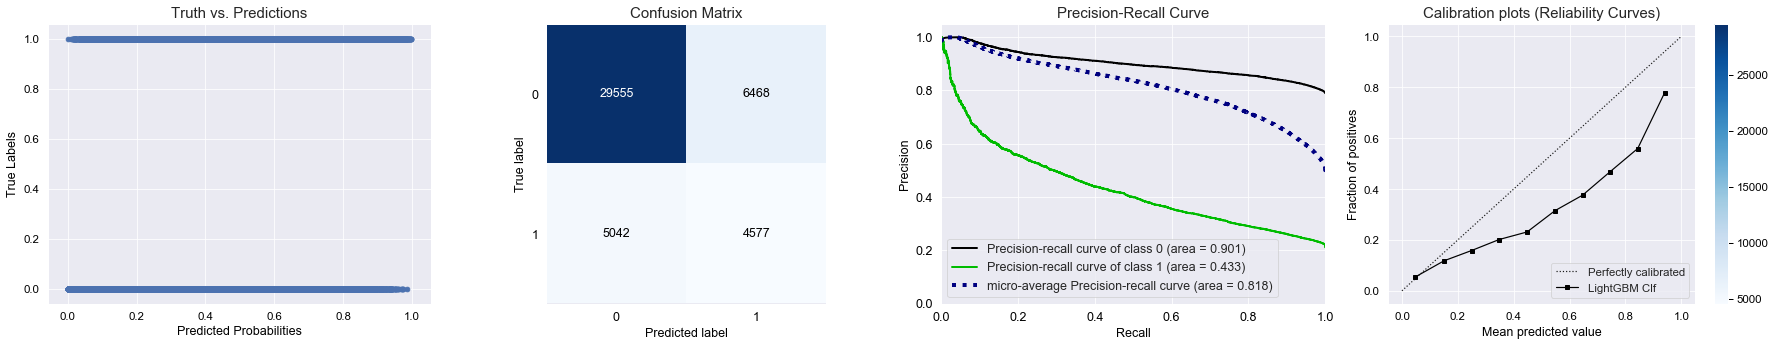

In [161]:
#del cv_models
#gc.collect() # train_df, drop_features + 
cv_models, oof_preds = lgbm_model.train_cv(train_df, repeated_folds=1, n_folds=5, cols_to_drop = drop_features+[target], target=target, 
                    qualitative_features=nominal_features+ordinal_features, search_space=search_space, primary_eval_metric=lgbm_eval_metric, 
                    early_stopping_rounds_per_model=500, mode="normal", keep_models_in_memory=True, valid_strategy="stratified",
                    valid_class=validation_strategy, custom_eval_metric=custom_f1, verbose=100, additional_metrics=None, classification_type="binary")
# seed: 23484,17160, model=43 & fold=19777 (best), 57652, 44918

### Assess incorrect predictions

In [127]:
# sample incorrect predictions
calib_df = pd.concat([train_df[["Unique_ID", "RESULT"]], pd.DataFrame(oof_preds[:,1], columns=["m1_oof_preds"])], axis=1)
calib_df.head()

,Unique_ID,RESULT,m1_oof_preds
0,CAX_Train_1,0,0.471
1,CAX_Train_2,0,0.323
2,CAX_Train_3,0,0.142
3,CAX_Train_4,0,0.235
4,CAX_Train_5,0,0.597


In [136]:
incorrect_preds = calib_df.query("(m1_oof_preds > 0.5 and RESULT == 0)") #or (m1_oof_preds < 0.5 and RESULT == 1)")
incorrect_preds.sample(5)

,Unique_ID,RESULT,m1_oof_preds
33576,CAX_Train_33577,0,0.596
5405,CAX_Train_5406,0,0.648
26955,CAX_Train_26956,0,0.705
36327,CAX_Train_36328,0,0.564
23260,CAX_Train_23261,0,0.570


In [137]:
incorrect_preds = incorrect_preds.merge(train_df, on = ["Unique_ID"], how="left")
print(incorrect_preds.shape)
incorrect_preds.head()

(7292, 92)


,Unique_ID,RESULT_x,m1_oof_preds,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PROPERTY TYPE,TERM,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT_y,x0,x1,x2,x3,x4,x5,x6,MOD_PROPERTY_VALUE,other_expenses,monthly_pay,mpr,mpa,pvrate,credit_risk,housing_expense,FSA_NOT_FUNDED,MORTGAGE_PURP_NOT_FUNDED,PTYPE_NOT_FUNDED,GENDER_NOT_FUNDED,NAICS_NOT_FUNDED,AGE_NOT_FUNDED,INCOME_NOT_FUNDED,fsa_mortgage_purpose_cnt,fsa_naics_cnt,fsa_naics_unique,fsa_income_type_cnt,FSA_CREDIT SCORE_max,FSA_CREDIT SCORE_min,FSA_CREDIT SCORE_mean,FSA_CREDIT SCORE_std,FSA_INCOME_max,FSA_INCOME_min,FSA_INCOME_mean,FSA_INCOME_std,FSA_MORTGAGE PAYMENT_max,FSA_MORTGAGE PAYMENT_min,FSA_MORTGAGE PAYMENT_mean,FSA_MORTGAGE PAYMENT_std,FSA_PROPERTY VALUE_max,FSA_PROPERTY VALUE_min,FSA_PROPERTY VALUE_mean,FSA_PROPERTY VALUE_std,FSA_TDS_max,FSA_TDS_min,FSA_TDS_mean,FSA_TDS_std,FSA_MORTGAGE AMOUNT_max,FSA_MORTGAGE AMOUNT_min,FSA_MORTGAGE AMOUNT_mean,FSA_MORTGAGE AMOUNT_std,FSA_GDS_max,FSA_GDS_min,FSA_GDS_mean,FSA_GDS_std,FSA_LTV_max,FSA_LTV_min,FSA_LTV_mean,FSA_LTV_std,FSA_RATE_max,FSA_RATE_min,FSA_RATE_mean,FSA_RATE_std,FSA_MOD_PROPERTY_VALUE_max,FSA_MOD_PROPERTY_VALUE_min,FSA_MOD_PROPERTY_VALUE_mean,FSA_MOD_PROPERTY_VALUE_std,rate_diff,rate_term,credit_risk_2,loan_rate_cscore
0,CAX_Train_5,0,0.597,5,350000.000,3342.000,29.590,80.000,34.850,360,592000.000,5.000,0,0,12.000,4,0,147000.000,0,4,762.000,0,0.351,-0.349,-0.191,-0.569,-0.112,0.555,-1.016,740000.000,1.172,1644.444,668.400,9.283,972.222,152.400,43497.300,0.240,0.255,0.220,0.218,0.228,0.220,0.210,91,9,16,75,851.000,0.000,670.109,92.882,561000.000,7000.000,123750.000,75796.193,7090.000,536.000,2514.609,1288.174,2300000.000,235000.000,628070.652,317562.404,90.000,7.300,37.716,10.099,1335000.000,62200.000,461779.566,224007.939,70.000,0.000,29.659,10.786,80.769,27.780,71.929,11.169,6.000,3.500,4.603,0.552,2050001.541,77847.309,643252.345,297288.772,0.361,60.000,3810.000,3884.514
1,CAX_Train_16,0,0.690,16,850000.000,4092.000,40.680,80.000,40.680,360,575000.000,6.000,0,2,12.000,8,2,111000.000,1,1,501.000,0,0.635,1.181,0.996,-1.061,-1.500,1.058,-0.883,718750.000,1.000,1597.222,682.000,11.367,2361.111,83.500,45154.800,0.158,0.255,0.191,0.190,0.212,0.221,0.215,127,46,17,64,851.000,0.000,657.174,128.063,561000.000,14000.000,110952.632,77868.447,8930.540,630.000,2402.013,1042.839,2300000.000,259000.000,593273.684,249852.525,76.260,0.000,36.868,9.144,1600000.000,135000.000,430903.062,183615.239,67.290,0.000,29.338,12.265,80.000,19.230,68.648,13.207,6.000,3.500,4.613,0.615,2461538.462,267900.000,629556.552,241404.388,1.361,72.000,3006.000,6886.228
2,CAX_Train_20,0,0.678,20,431000.000,2109.000,25.640,80.000,26.260,360,387858.920,4.750,1,3,12.000,3,0,125000.000,1,3,669.000,0,-0.178,-0.737,-0.005,-0.689,-0.378,0.408,0.023,484823.650,1.023,1077.386,444.000,5.858,1197.222,140.842,32050.000,0.236,0.172,0.195,0.218,0.207,0.209,0.215,126,14,14,52,851.000,0.000,667.847,121.779,267000.000,16000.000,88346.591,44472.133,3475.000,518.000,1660.386,600.483,800000.000,123000.000,380579.545,137105.734,90.000,1.760,38.867,10.470,560000.000,77000.000,280383.332,105452.406,70.000,0.000,25.886,13.652,80.000,15.620,71.567,10.512,6.000,3.500,4.621,0.543,800000.000,123000.000,394159.723,142025.051,0.111,57.000,3177.750,2753.856
3,CAX_Train_37,0,0.688,37,808000.000,3298.000,17.640,80.000,45.810,360,646400.000,4.000,1,0,12.000,4,0,165000.000,1,12,745.000,0,0.866,-0.608,-0.760,-0.273,0.403,0.173,-0.132,808000.000,2.511,1795.556,824.500,9.161,2244.444,186.250,29106.000,0.243,0.172,0.220,0.218,0.234,0.220,0.215,83,6,15,50,851.000,0.000,682.159,126.897,500000.000,7000.000,119099.338,57450.240,6325.000,416.000,2475.914,843.984,1700000.000,215000.000,617185.430,213197.105,50.520,8.470,37.111,7.609,1200000.000,60000.000,457659.578,151663.325,48.960,0.000,27.064,10.974,80.000,27.910,72.711,10.882,6.000,3.500,4.526,0.585,1640016.400,214976.711,632493.070,204791.300,-0.639,48.0

In [142]:
#describe_numeric(incorrect_preds, incorrect_preds.select_dtypes(include=["number"]).columns)
describe_categorical(incorrect_preds, nominal_features+ordinal_features)

,MORTGAGE PURPOSE,PROPERTY TYPE,GENDER,NAICS CODE,AGE RANGE,INCOME TYPE
count_non_missing_,7292,7292,7292,7292,7292,7292
count_missing,0,0,0,0,0,0
top_,0,0,0,1,3,0
freq_,4539,5229,4233,1837,1214,3572
%freq_,62.25%,71.71%,58.05%,25.19%,16.65%,48.99%
dtype_,int64,int64,int64,int64,int64,int64
nunique_,2,8,3,19,11,18
%missing_,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%
intrinsic_factor,0.956,1.519,1.331,3.494,3.190,1.538


In [138]:
correct_preds = calib_df.query("(m1_oof_preds < 0.5 and RESULT == 0) or (m1_oof_preds > 0.5 and RESULT == 1)") #or (m1_oof_preds < 0.5 and RESULT == 1)")

correct_preds = correct_preds.merge(train_df, on = ["Unique_ID"], how="left")
print(correct_preds.shape)
#correct_preds.head()

(33640, 92)


In [143]:
#describe_numeric(correct_preds, correct_preds.select_dtypes(include=["number"]).columns)
describe_categorical(correct_preds, nominal_features+ordinal_features)

,MORTGAGE PURPOSE,PROPERTY TYPE,GENDER,NAICS CODE,AGE RANGE,INCOME TYPE
count_non_missing_,33640,33640,33640,33640,33640,33640
count_missing,0,0,0,0,0,0
top_,1,0,0,1,3,0
freq_,19104,21130,18034,8248,5656,15894
%freq_,56.79%,62.81%,53.61%,24.52%,16.81%,47.25%
dtype_,int64,int64,int64,int64,int64,int64
nunique_,2,8,3,19,11,21
%missing_,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%
intrinsic_factor,0.987,1.747,1.416,3.472,3.215,1.651


In [102]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=500, max_depth=None, criterion="entropy", min_samples_leaf=5, max_features=None, 
                                              max_leaf_nodes=None, bootstrap=False, oob_score=False, n_jobs=-1, random_state=23, 
                                              verbose=1, class_weight="balanced", warm_start=False)
cv_preds = cross_val_predict(rf, correct_preds["m1_oof_preds"][:, np.newaxis], correct_preds["RESULT"], 
                             cv=StratifiedKFold(5, shuffle=True, random_state=rs_seed), 
                             method="predict", verbose=1, n_jobs=None, fit_params={})

print(metrics.f1_score(correct_preds["RESULT"].values, cv_preds, average="macro"))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs

0.9998242682939253


### Predict

In [118]:
# cv predictions
preds = lgbm_model.cv_predict(cv_models, test_df, cols_to_drop=drop_features, row_id_name=object_id, prediction_type="binary|class")
print(preds.shape)
preds.head()

Applying model 0...
Applying model 1...
Applying model 2...
Applying model 3...
Applying model 4...
(15214, 2)


,Unique_ID,target
0,CAX_Test_1,0
1,CAX_Test_2,0
2,CAX_Test_3,0
3,CAX_Test_4,0
4,CAX_Test_5,0


In [119]:
preds.columns = submission_fields
preds[submission_fields[1]] = preds[submission_fields[1]].map(lambda x:"FUNDED" if x == 0 else "NOT FUNDED")
preds.to_csv("CAX_MortgageModeling_Submission.csv", index=False)

In [71]:
# LGBM Model Diagnostics
lgbm_model.run_permutation_importance(train_df, drop_features+[target], cv_models, target, lgbm_eval_metric, type_model="binary")

Base metric score: 0.633


,Feature,Avg_Reduction,Std_Dev
32,FSA_NOT_FUNDED,0.0307,0.0013
28,mpa,0.0203,0.0048
1,MORTGAGE PAYMENT,0.0190,0.0030
27,mpr,0.0147,0.0046
24,MOD_PROPERTY_VALUE,0.0133,0.0034
4,TDS,0.0124,0.0019
3,LTV,0.0112,0.0013
6,MORTGAGE AMOUNT,0.0100,0.0032
26,monthly_pay,0.0095,0.0028
8,MORTGAGE PURPOSE,0.0067,0.0019


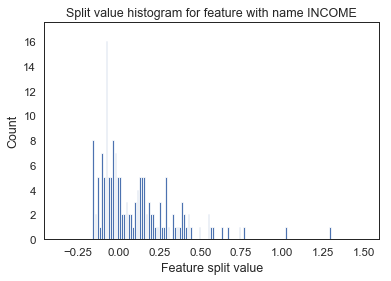

In [29]:
with sns.axes_style("white"):
    lgbm.plot_split_value_histogram(cv_models[0][1], "INCOME")
    plt.grid(False)

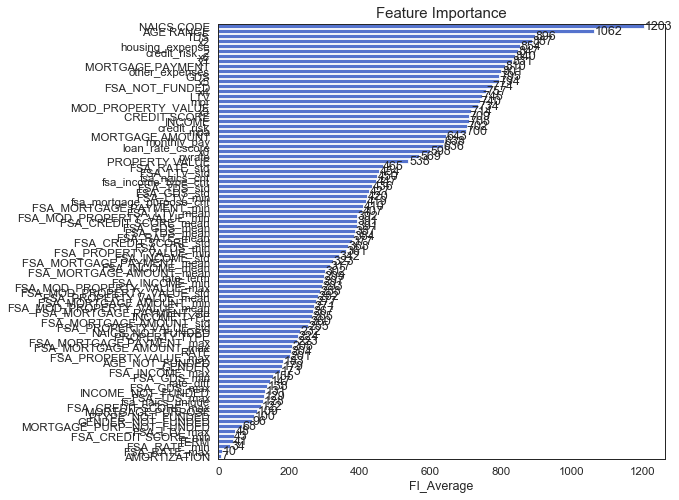

In [125]:
# feature importance
lgbm_model.run_feat_importance(cv_models, train_df.drop(drop_features+[target], axis=1).columns, importance_type="split")
lgbm_model.run_feat_importance(cv_models, train_df.drop(drop_features+[target], axis=1).columns, importance_type="gain")
lgbm_model.plot_feat_importance(importance_type="split")

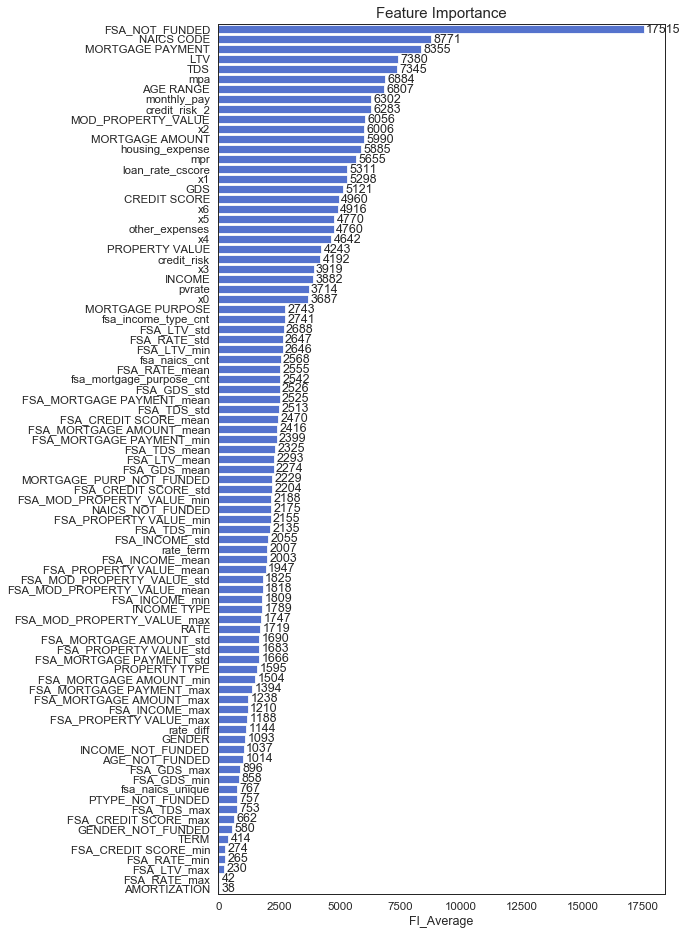

In [126]:
lgbm_model.plot_feat_importance(importance_type="gain", figsize=(8,16))

In [240]:
lgbm_model.run_shap_importance(cv_models, train_df, cols_to_drop=drop_features+[target])

Shape of SHAP on validation set: (9129, 20)
Shape of SHAP on validation set: (9129, 20)
Shape of SHAP on validation set: (9129, 20)
Shape of SHAP on validation set: (9128, 20)
Shape of SHAP on validation set: (9127, 20)


In [35]:
lgbm_model.get_shap_frame()

,Avg_SHAP,Std_dev_SHAP,Avg_POS_SHAP,Std_POS_SHAP,Avg_NEG_SHAP,Std_NEG_SHAP,Avg_ZEROS_SHAP,Std_ZEROS_SHAP
Features,,,,,,,,
PAYMENT FREQUENCY,483.917,91.861,571.400,23.972,8557.000,23.791,0.000,0.000
FSA,348.258,16.230,4429.400,47.982,4699.000,48.104,0.000,0.000
MORTGAGE AMOUNT,267.318,40.877,5022.800,83.801,4105.600,84.030,0.000,0.000
MORTGAGE PURPOSE,224.605,8.033,4887.200,45.723,4241.200,46.258,0.000,0.000
LTV,154.324,5.465,4883.800,118.272,4244.600,118.279,0.000,0.000
RATE,141.404,14.827,3961.200,366.560,5167.200,366.137,0.000,0.000
TDS,113.616,4.335,6007.600,361.460,3120.800,361.440,0.000,0.000
NAICS CODE,104.270,8.751,4712.400,251.190,4416.000,251.521,0.000,0.000
MORTGAGE PAYMENT,96.524,8.196,3454.800,321.624,5673.600,321.044,0.000,0.000


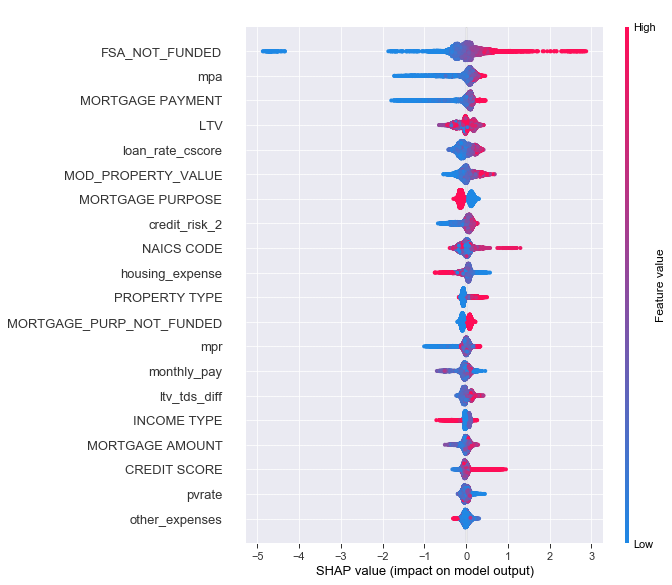

In [162]:
lgbm_model.shap_summaryplot(train_df, cv_models[0][2], cv_models[0][1], drop_features+[target])

In [202]:
lgbm_model.shap_obs_explanation(train_df, cv_models[0][2][0:10], cv_models[0][1], drop_features+[target])


SHAP base value: 0.761909455701657


In [165]:
shap_values = lgbm_model.get_shap_values(train_df, cv_models[0][2], cv_models[0][1], drop_features+[target])

In [145]:
train_df.columns

Index(['Unique_ID', 'MORTGAGE NUMBER', 'PROPERTY VALUE', 'MORTGAGE PAYMENT',
       'GDS', 'LTV', 'TDS', 'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE',
       'MORTGAGE PURPOSE', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT', 'x0',
       'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'MOD_PROPERTY_VALUE',
       'other_expenses', 'monthly_pay', 'mpr', 'mpa', 'pvrate', 'credit_risk',
       'housing_expense', 'FSA_NOT_FUNDED', 'MORTGAGE_PURP_NOT_FUNDED',
       'PTYPE_NOT_FUNDED', 'GENDER_NOT_FUNDED', 'NAICS_NOT_FUNDED',
       'AGE_NOT_FUNDED', 'INCOME_NOT_FUNDED', 'fsa_mortgage_purpose_cnt',
       'fsa_naics_cnt', 'fsa_naics_unique', 'fsa_income_type_cnt',
       'FSA_CREDIT SCORE_max', 'FSA_CREDIT SCORE_min', 'FSA_CREDIT SCORE_mean',
       'FSA_CREDIT SCORE_std', 'FSA_INCOME_max', 'FSA_INCOME_min',
       'FSA_INCOME_mean', 'FSA_INCOME_std', 'FSA_MORTGAGE PAYMENT_max',
       'FSA_MORTGAGE PAYMENT_min', 'FSA_MORTGAGE PAYMEN

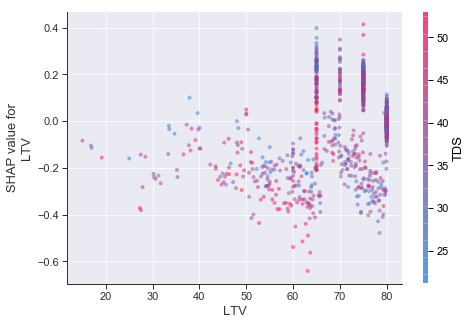

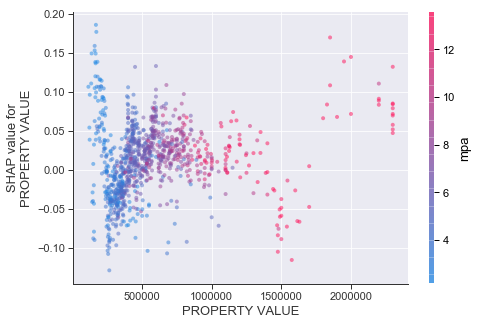

In [168]:
lgbm_model.plot_shap_dependence(train_df, train_df, cv_models[0][2], drop_features+[target], shap_values, ["LTV", "PROPERTY VALUE"], target, interaction_feature="auto")

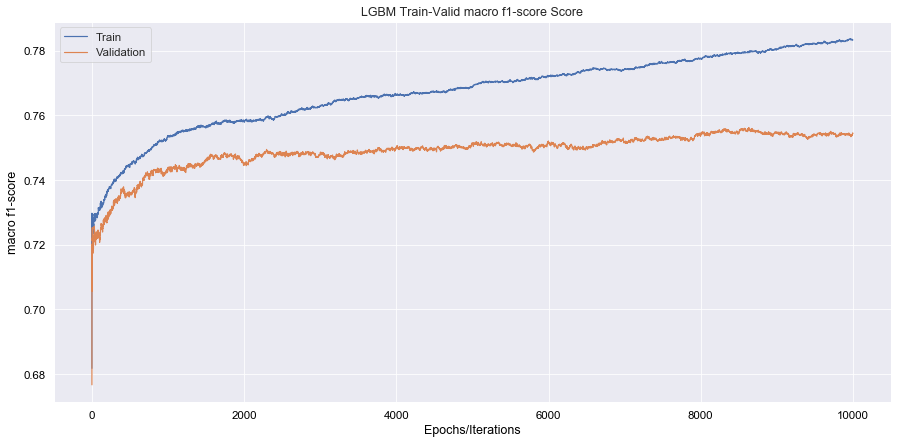

In [158]:
lgbm_model.plot_loss(cv_models[0][1], "macro f1-score")

### Negative Downsampling

In [124]:
# negative down sampling

# model config for LightGBM
search_space = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.01, 'max_depth': 8, # max_depth =63, learning_rate=0.1
                'num_leaves': 255, 'n_estimators': 1000, 'n_jobs': 4, 'min_child_samples': 200,  # num_leaves=31, min_child_samples=100
                'subsample': 0.95, 'bagging_freq': 1, 'colsample_bytree': 0.3, 
                'bagging_seed': 1, 'min_child_weight': 1e-3, 'reg_alpha': 0, 'reg_lambda': 0, # reg_alpha=reg_lambda=0.01
                "max_bin": 100, "min_split_gain": 0, #255
                "subsample_for_bin": 1000000, # optional
                'metric': ["macro f1-score"], 'metric_freq':1, "device_type": "cpu", "seed": 44, 
                "silent": True, "scale_pos_weight": 3, "boost_from_average": False}  # "scale_pos_weight": 0.34, "class_weight": "balanced"

In [61]:
m_seeds = rs_seed.random_integers(1, 10000, 1)
m_models = []
m_results = []

for m_repeat in m_seeds:
    kfold = KFold(2, shuffle=True, random_state=m_repeat) # test_size=9615
    m_majority_df, m_minority_df = train_df.query("RESULT == 0"), train_df.query("RESULT == 1")
    for fold_idx, tidx in enumerate(kfold.split(m_majority_df)):
        print(f"============ Seed: {m_repeat}, Iteration: {fold_idx} ================")
        _, train_idx = tidx[0], tidx[1]
        print(train_idx.shape)
        X = pd.concat([m_majority_df.iloc[train_idx, :], m_minority_df], axis=0)
        y = X[target]
        X = X.drop(drop_features+[target], axis=1)
        print(X.shape)
        
        # fit model on entire training set
        m_lgbm_model = lgbm.LGBMClassifier(**search_space)
        m_lgbm_model.fit(X, y, verbose=10, 
                         feature_name=list(X.columns), 
                         categorical_feature=nominal_features+ordinal_features
                         )
        print("Score: {}".format(lgbm_eval_metric(y, m_lgbm_model.predict_proba(X)[:,1])))
        m_models.append(m_lgbm_model) # save trained model
        
        # cross-validate
        del m_lgbm_model
        m_lgbm_model = lgbm.LGBMClassifier(**search_space)
        cv_preds = cross_val_predict(m_lgbm_model, X, y, 
                                     cv=StratifiedKFold(5, shuffle=True, random_state=m_repeat), 
                                     method="predict", 
                                     fit_params={#"early_stopping_rounds": 100, "verbose": 50, 
                                                 "feature_name": list(X.columns), "categorical_feature": nominal_features+ordinal_features,
                                                 #"eval_set": [(train_pool, y),(valid_pool, y_val)]
                                                 },
                                     verbose=0, n_jobs=None)
        m_results_ = metrics.f1_score(y, cv_preds, average="macro")
        m_results.append(m_results_) # save results
        print("CV Score: {}".format(m_results_))
        
        # clean up
        del X, y, train_idx, m_results_, m_lgbm_model
        gc.collect()

============ Seed: 6150, Iteration: 0 ================
(18012,)
(27631, 20)
Score: 0.7532987093619335
CV Score: 0.6144616515174967
============ Seed: 6150, Iteration: 1 ================
(18011,)
(27630, 20)
Score: 0.7548157975963552
CV Score: 0.6168825131217156


In [54]:
preds = 0
num_models = len(m_models)
for m_model in m_models:
    preds += sp.stats.rankdata(m_model.predict_proba(test_df.drop(drop_features, axis=1), num_iteration=m_model.best_iteration_)[:,1]) / test_df.shape[0]

preds /= num_models
preds = (logit(preds) > 0).astype(np.int8)
preds = pd.DataFrame({submission_fields[0]: test_df[submission_fields[0]], "target": preds})
preds.head()

,Unique_ID,target
0,CAX_Test_1,1
1,CAX_Test_2,0
2,CAX_Test_3,0
3,CAX_Test_4,0
4,CAX_Test_5,1


In [55]:
preds.columns = submission_fields
preds[submission_fields[1]] = preds[submission_fields[1]].map(lambda x:"FUNDED" if x == 0 else "NOT FUNDED")
preds.to_csv("CAX_MortgageModeling_Submission.csv", index=False)

### CatBoost based Model

In [82]:
# model config for CatBoost
def eval_metric_(y_true, y_pred):
    approxes = logit(y_pred)
    #eval_metric(y_true, approxes, "TotalF1")[0]
    return metrics.f1_score(y_true, (approxes>0).astype(np.int8), average="macro")

class F1Metric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        approx = (np.fromiter(approxes[0], np.float64) > 0).astype(np.int8)
        target = np.fromiter(target, np.int8)
        return metrics.f1_score(target, approx, average="macro"), 0.0

search_space = {"learning_rate": 0.1, "n_estimators": 1000, "max_depth": 10, "bootstrap_type": "Bayesian", "colsample_bylevel": 1, 
                "max_ctr_complexity": 6, "one_hot_max_size": 4, "random_seed": 41, "verbose": 25, #"subsample": 0.95,
                "task_type": "GPU", "reg_lambda": 1, "max_bin": 32, "eval_metric": "AUC", "objective": "Logloss", #"Logloss", TotalF1
                "thread_count": 6, "gpu_cat_features_storage": "GpuRam", "metric_period": 1, "train_dir": "./catboost_artifacts", 
                "save_snapshot": False, "name": "exp1", "snapshot_file": "exp2.bkp", "leaf_estimation_method": "Gradient", "scale_pos_weight": 3}
    
validation_strategy = partial(StratifiedKFold, n_splits=2, shuffle=True)

In [83]:
catgbm_model = CatCVClassifier()

Catboost: 0.14.2
Creating metric visualizer directory to measure bias-variance trade-off across CV runs...


Seed: 14149
[INFO] Using stratified kFold validation...

============================= Iter1_fold0 ============================
(22820,) [ 3  6 10 11 17] ...
(22822,) [0 1 2 4 5] ...

[INFO] Train Pool: (22820, 83) ::: Validation Pool: (22822, 83)
{'gpu_cat_features_storage': 'GpuRam', 'scale_pos_weight': 3, 'max_bin': 32, 'objective': 'Logloss', 'reg_lambda': 1, 'colsample_bylevel': 1, 'n_estimators': 1000, 'max_depth': 10, 'bootstrap_type': 'Bayesian', 'task_type': 'GPU', 'snapshot_file': 'exp2.bkp', 'save_snapshot': False, 'eval_metric': 'AUC', 'train_dir': './metric_visualizer\\Iter1_fold0', 'name': 'exp1', 'one_hot_max_size': 4, 'max_ctr_complexity': 6, 'metric_period': 1, 'verbose': 25, 'random_seed': 41, 'thread_count': 6, 'leaf_estimation_method': 'Gradient', 'loss_function': 'Logloss', 'learning_rate': 0.1} 

[INFO] Training...
0:	learn: 0.6684592	test: 0.6568028	best: 0.6568028 (0)	total: 563ms	remaining: 9m 22s
25:	learn: 0.7519604	test: 0.7062742	best: 0.7062742 (25)	total:

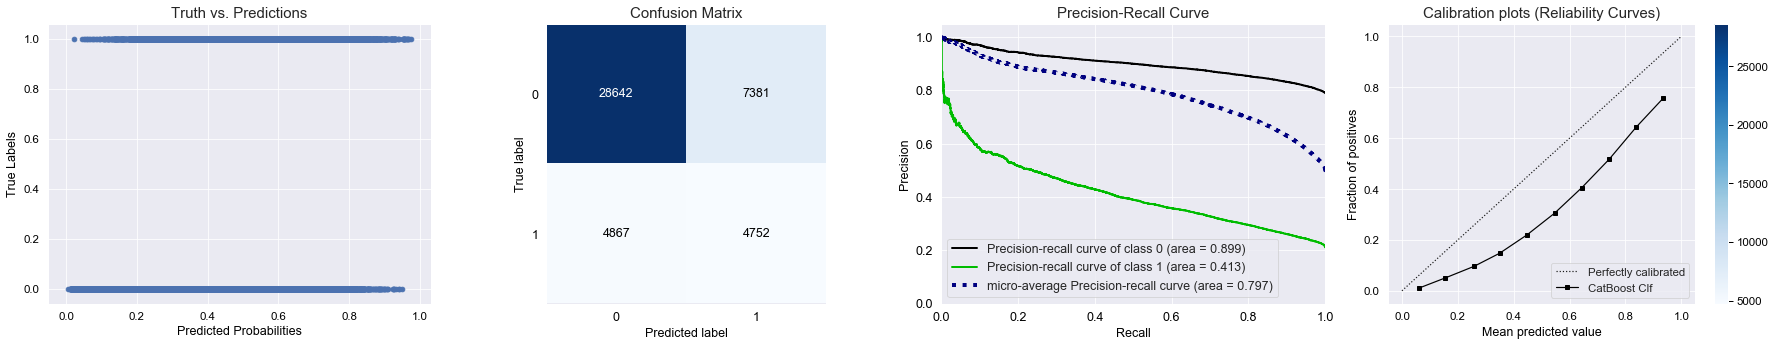

In [84]:
#del cat_cv_models
#gc.collect()

cat_cv_models = catgbm_model.train_cv(train_df, repeated_folds=1, n_folds=5, cols_to_drop = drop_features + [target], target=target,
                                      qualitative_features=nominal_features+ordinal_features, search_space=search_space, primary_eval_metric=eval_metric_, 
                                      early_stopping_rounds_per_model=30, mode="normal", keep_models_in_memory=True, valid_strategy="stratified",
                                      valid_class=validation_strategy, additional_metrics=None, classification_type="binary")

In [46]:
# cv predictions
preds = catgbm_model.cv_predict(cat_cv_models, test_df, cols_to_drop=drop_features, row_id_name=object_id, prediction_type="binary|class")
print(preds.shape)
preds.head()

Applying model 0...
Applying model 1...
Applying model 2...
Applying model 3...
Applying model 4...
(15214, 2)


,Unique_ID,target
0,CAX_Test_1,1
1,CAX_Test_2,1
2,CAX_Test_3,1
3,CAX_Test_4,1
4,CAX_Test_5,1


In [47]:
preds.columns = submission_fields
preds[submission_fields[1]] = preds[submission_fields[1]].map(lambda x:"FUNDED" if x == 1 else "NOT FUNDED")
preds.to_csv("CAX_MortgageModeling_Submission_catboost.csv", index=False)

In [180]:
# CatBoost Model Diagnostics
catgbm_model.run_permutation_importance(train_df, drop_features+[target], cat_cv_models, target, eval_metric_, type_model="binary")

Base metric score: 0.759


,Feature,Avg_Reduction,Std_Dev
6,MORTGAGE AMOUNT,0.0438,0.0101
4,TDS,0.0209,0.0016
1,MORTGAGE PAYMENT,0.0204,0.0080
3,LTV,0.0200,0.0015
12,FSA,0.0163,0.0023
9,PAYMENT FREQUENCY,0.0131,0.0037
8,MORTGAGE PURPOSE,0.0093,0.0033
7,RATE,0.0089,0.0021
18,CREDIT SCORE,0.0069,0.0015
0,PROPERTY VALUE,0.0067,0.0026


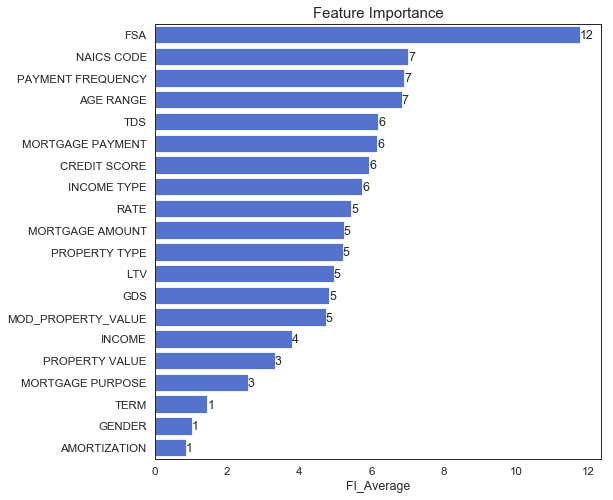

In [79]:
catgbm_model.run_feat_importance(cat_cv_models)
catgbm_model.plot_feat_importance()

In [182]:
catgbm_model.run_feature_interactions(cat_cv_models)

In [183]:
catgbm_model.feat_interact_df

,Count,Sum,Std,Ratio_Sum_Count
PAYMENT FREQUENCY,80.000,124.194,1.962,3.105
TDS,80.000,61.825,0.922,1.742
MORTGAGE AMOUNT,80.000,62.418,1.126,1.642
LTV,80.000,65.955,0.916,1.541
AGE RANGE,80.000,72.331,1.477,1.533
GDS,80.000,64.324,0.707,1.405
NAICS CODE,80.000,76.987,0.945,1.373
PROPERTY TYPE,80.000,54.131,1.143,1.316
MORTGAGE PAYMENT,80.000,53.928,0.910,1.311
RATE,80.000,44.022,0.512,1.098


In [184]:
catgbm_model.run_shap_importance(cat_cv_models, train_df, drop_features+[target], target, nominal_features+ordinal_features)
catgbm_model.get_shap_frame()

The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/664 trees processed	passed time: 3.28s	remaining time: 13.7s sec
664/664 trees processed	passed time: 13s	remaining time: 0us sec
Processing documents...
128/9129 documents processed	passed time: 10.5ms	remaining time: 740ms sec
9129/9129 documents processed	passed time: 394ms	remaining time: 0us sec
Shape of SHAP on validation set: (9129, 20)


The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/376 trees processed	passed time: 2.72s	remaining time: 5.27s sec
376/376 trees processed	passed time: 5.82s	remaining time: 0us sec
Processing documents...
128/9129 documents processed	passed time: 3.87ms	remaining time: 272ms sec
9129/9129 documents processed	passed time: 197ms	remaining time: 0us sec
Shape of SHAP on validation set: (9129, 20)


The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/434 trees processed	passed time: 3.44s	remaining time: 8.22s sec
434/434 trees processed	passed time: 9.34s	remaining time: 0us sec
Processing documents...
128/9129 documents processed	passed time: 9.16ms	remaining time: 644ms sec
9129/9129 documents processed	passed time: 296ms	remaining time: 0us sec
Shape of SHAP on validation set: (9129, 20)


The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/1104 trees processed	passed time: 3.96s	remaining time: 30.2s sec
1104/1104 trees processed	passed time: 16.6s	remaining time: 0us sec
Processing documents...
128/9128 documents processed	passed time: 10.3ms	remaining time: 724ms sec
9128/9128 documents processed	passed time: 416ms	remaining time: 0us sec
Shape of SHAP on validation set: (9128, 20)


The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/675 trees processed	passed time: 2.86s	remaining time: 12.2s sec
675/675 trees processed	passed time: 13.7s	remaining time: 0us sec
Processing documents...
128/9127 documents processed	passed time: 7.45ms	remaining time: 524ms sec
9127/9127 documents processed	passed time: 401ms	remaining time: 0us sec
Shape of SHAP on validation set: (9127, 20)


,Avg_SHAP,Std_dev_SHAP,Avg_POS_SHAP,Std_POS_SHAP,Avg_NEG_SHAP,Std_NEG_SHAP,Avg_ZEROS_SHAP,Std_ZEROS_SHAP
Features,,,,,,,,
PAYMENT FREQUENCY,583.963,41.280,948.000,727.167,8180.400,727.866,0.000,0.000
MORTGAGE AMOUNT,267.017,50.340,4657.400,314.112,4471.000,313.836,0.000,0.000
MORTGAGE PURPOSE,204.525,3.175,4883.600,22.339,4244.800,22.149,0.000,0.000
LTV,145.285,17.812,4806.400,311.021,4322.000,311.641,0.000,0.000
RATE,131.952,13.904,3961.000,540.684,5167.400,540.957,0.000,0.000
FSA,128.296,14.307,5546.000,154.210,3582.400,154.175,0.000,0.000
TDS,123.790,3.336,7073.000,726.561,2055.400,727.045,0.000,0.000
MORTGAGE PAYMENT,81.151,27.261,4793.200,504.784,4335.200,504.934,0.000,0.000
PROPERTY VALUE,69.016,16.832,5241.000,575.284,3887.400,575.231,0.000,0.000


The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/986 trees processed	passed time: 3.33s	remaining time: 22.3s sec
986/986 trees processed	passed time: 38.9s	remaining time: 0us sec
Processing documents...
128/22822 documents processed	passed time: 40.4ms	remaining time: 7.17s sec
22822/22822 documents processed	passed time: 2.79s	remaining time: 0us sec


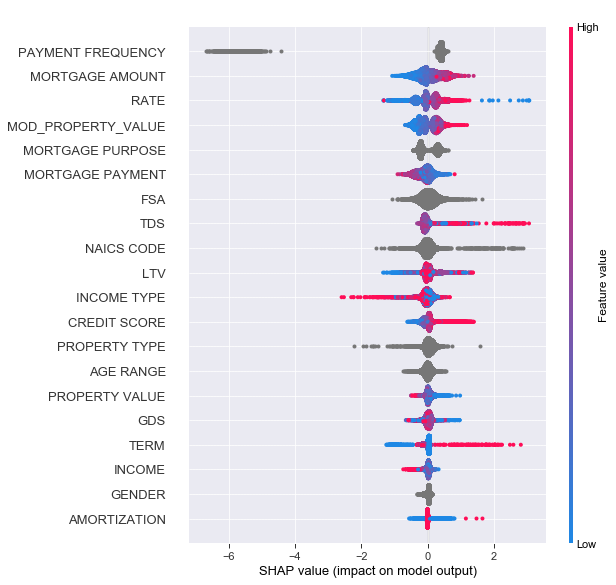

In [78]:
catgbm_model.shap_summaryplot(train_df, cat_cv_models[0][2], cat_cv_models[0][1], target, nominal_features+ordinal_features, drop_features+[target])

In [186]:
catgbm_model.shap_obs_explanation(train_df, cat_cv_models[0][2][0:100], cat_cv_models[0][1], target, nominal_features+ordinal_features, drop_features+[target])

The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/664 trees processed	passed time: 3.36s	remaining time: 14.1s sec
664/664 trees processed	passed time: 14.6s	remaining time: 0us sec
Processing documents...
100/100 documents processed	passed time: 6.15ms	remaining time: 0us sec

SHAP base value: 0.682942631017082


In [187]:
shap_values = catgbm_model.get_shap_values(train_df, cat_cv_models[0][2], cat_cv_models[0][1], target, nominal_features+ordinal_features, drop_features+[target])
print(shap_values.shape)

The model has complex ctrs, so the SHAP values will be calculated approximately.


Processing trees...
128/664 trees processed	passed time: 2.98s	remaining time: 12.5s sec
664/664 trees processed	passed time: 12.4s	remaining time: 0us sec
Processing documents...
128/9129 documents processed	passed time: 5.91ms	remaining time: 415ms sec
9129/9129 documents processed	passed time: 380ms	remaining time: 0us sec
(9129, 20)


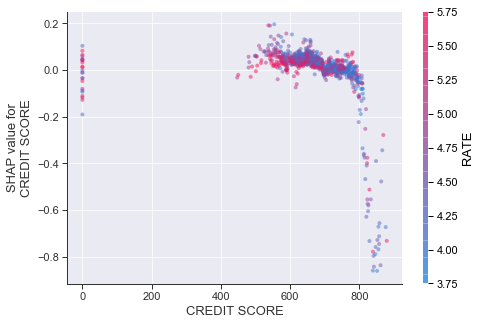

In [194]:
catgbm_model.plot_shap_dependence(train_df, cat_cv_models[0][2], drop_features+[target], shap_values, ["CREDIT SCORE"])

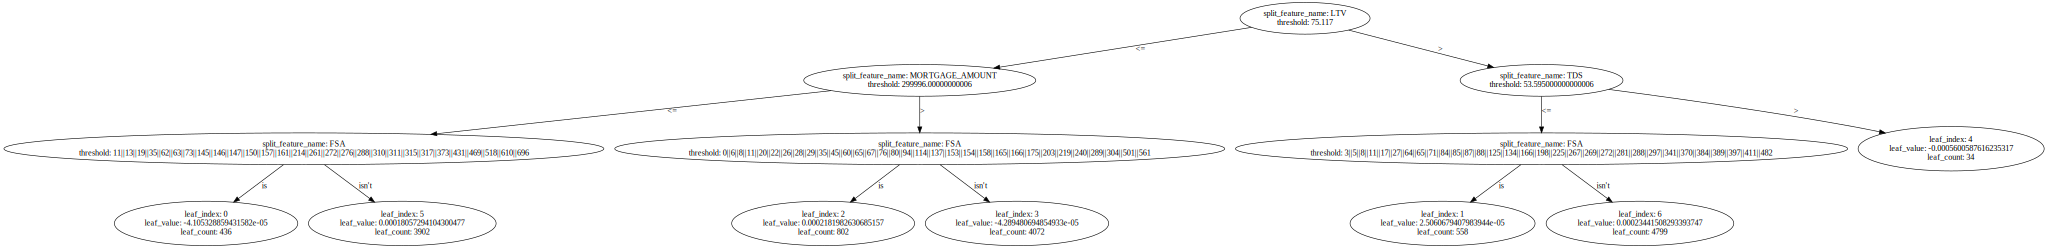

In [190]:
# LightGBM Tree
lgbm.create_tree_digraph(cv_models[0][1], show_info=["leaf_count"])

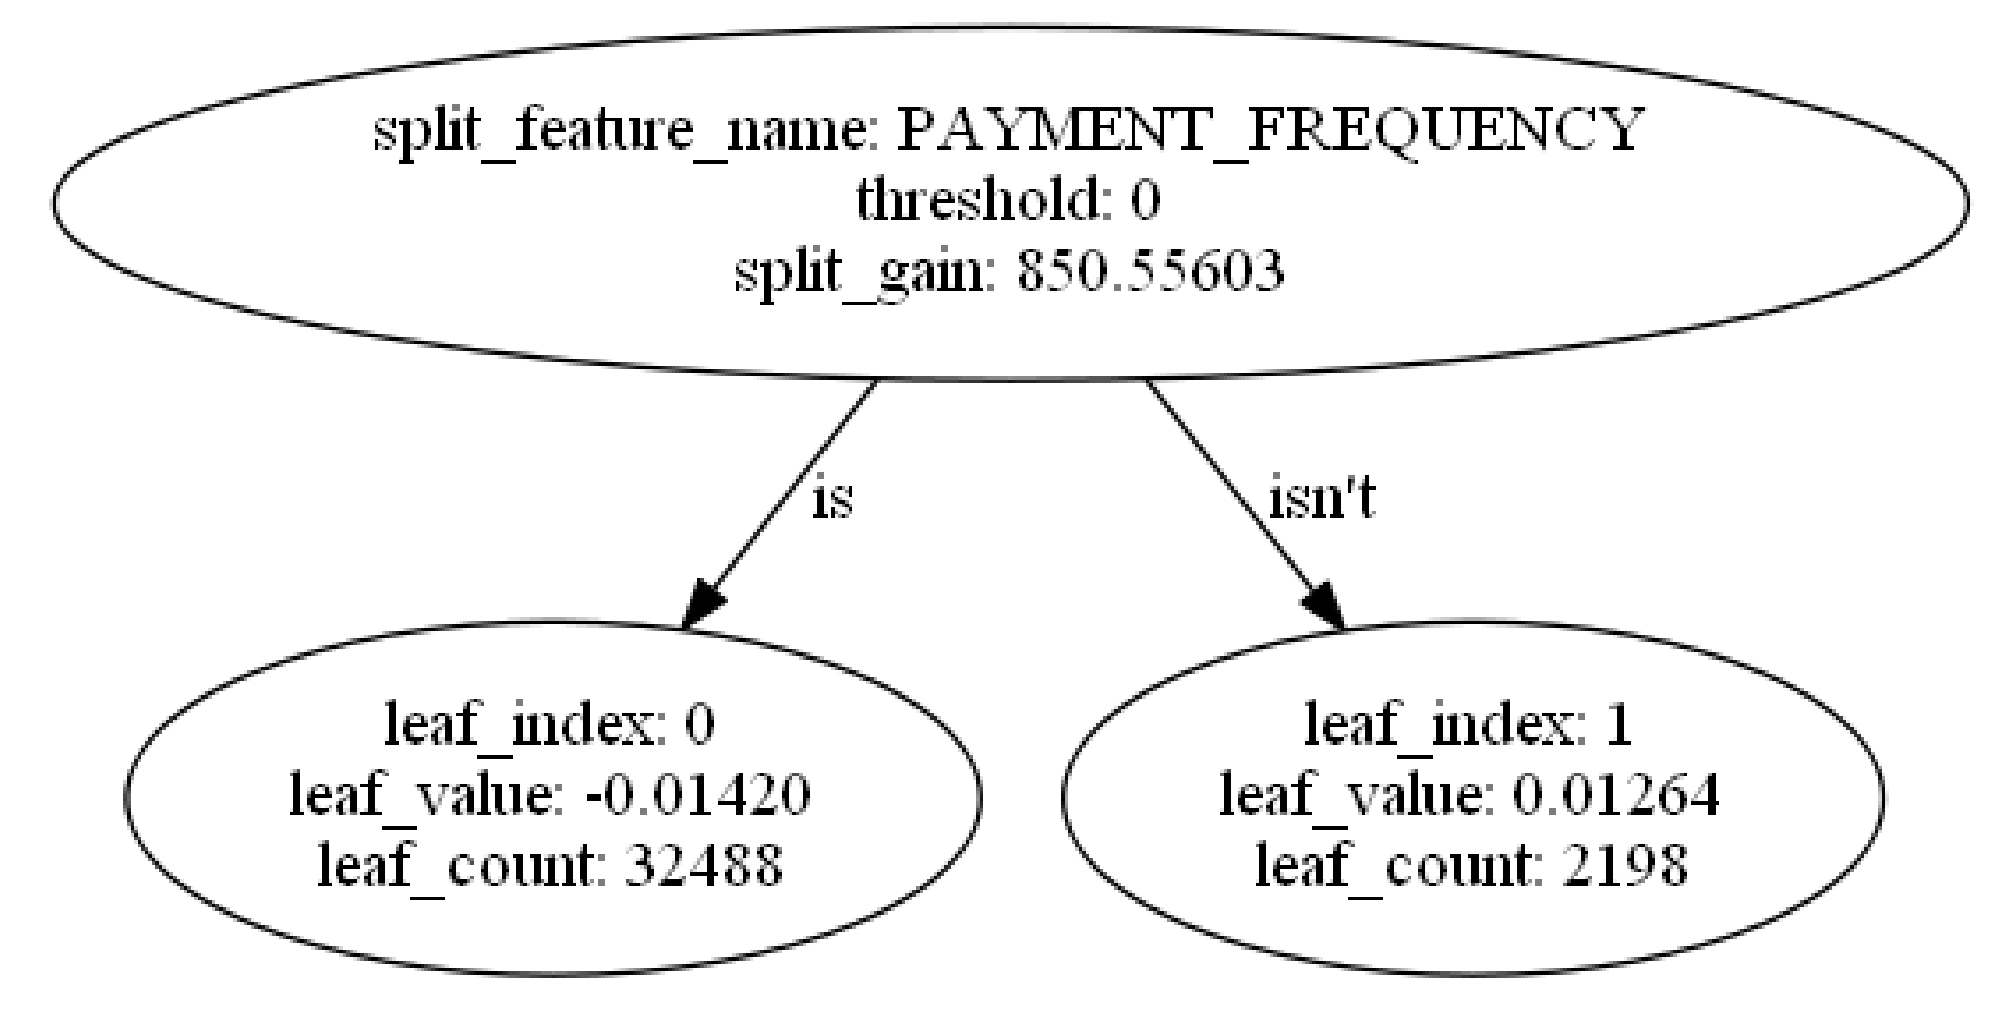

In [33]:
lgbm.plot_tree(cv_models[3][1], show_info=["leaf_count", "split_gain"], figsize=(35,40), precision=5, tree_index=3)

In [302]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [ ]:
oof_preds = np.zeros(train_df.shape[0])

for fold_idx, cat_cm, valid_idx in cat_cv_models:
    oof_preds[valid_idx] = cat_cm.predict_proba(train_df.drop(drop_features+[target],axis=1).iloc[valid_idx, :])[:,1]

temp_df = pd.concat([train_df[["RESULT"]], pd.Series(oof_preds, name="pred")], axis=1)
temp_df.head()

#iso_reg = IsotonicRegression()
#temp_df["calibrated_pred"] = iso_reg.fit_transform(temp_df["pred"], temp_df["RESULT"])

#thresholds = np.arange(0,1,0.01)
#score_dict = {}
#for threshold in thresholds:
    #score_dict[threshold] = metrics.f1_score(temp_df["RESULT"], (temp_df["calibrated_pred"] >= threshold).astype(np.int8), average="macro")
    
# lightgbm
#oof_lgbm_preds = np.zeros(train_df.shape[0])

#for fold_idx, lgb_cm, valid_idx in cv_models:
#    oof_lgbm_preds[valid_idx] = lgb_cm.predict_proba(train_df.drop(drop_features+[target],axis=1).iloc[valid_idx, :])[:,1]

#temp_lgbm_df = pd.concat([train_df[["RESULT"]], pd.Series(oof_lgbm_preds, name="pred")], axis=1)
#temp_lgbm_df.head()